# TESS Atlas fit for TOI 229

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 229.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-229.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-229.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-229.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 229

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 229 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

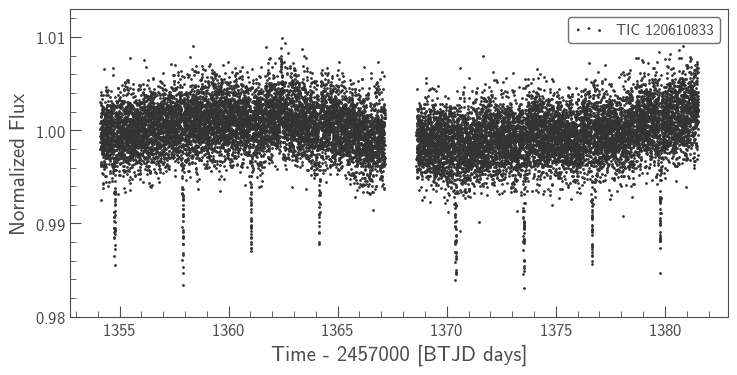

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -47556.17170309939 -> -47522.31368165322


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -43000.644953659554 -> -42910.51362557057


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -42910.513625570566 -> -41023.56378713865


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -41023.56378713865 -> -41023.172492011305


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -41023.172492011305 -> -41023.16683171731


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -41023.16683171731 -> -41022.76692130438


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -41022.76692130438 -> -40787.87393944198


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -40787.873939441975 -> -40787.873939441975


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -40787.87393944198 -> -40787.87393944198


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -40787.87393944198 -> -40787.87393944198


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -40787.87393944198 -> -40787.87393944198


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -40787.87393944198 -> -40787.87393944198


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -40787.87393944198 -> -40787.87393944198


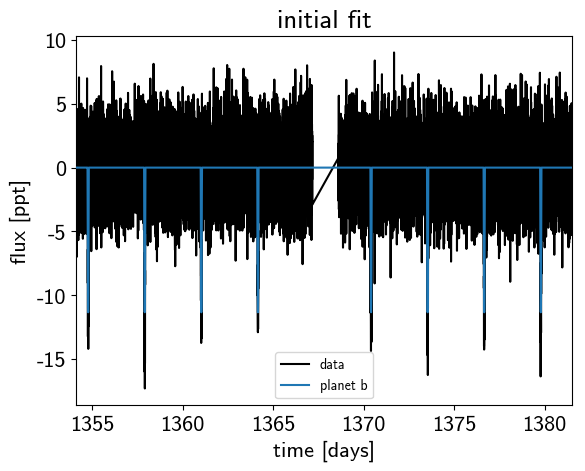

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:06, 13.55draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:00<00:08, 11.11draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:23,  3.82draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:19,  4.66draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:31,  2.87draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:29,  2.90draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:24,  3.58draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:32,  2.61draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:30,  2.74draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:27,  2.95draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:29,  2.72draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:29,  2.70draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:31,  2.51draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:06<00:30,  2.53draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:32,  2.36draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:07<00:32,  2.34draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:07<00:33,  2.26draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:08<00:33,  2.24draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:08<00:32,  2.24draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:09<00:29,  2.44draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:09<00:30,  2.34draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:09<00:27,  2.51draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:10<00:27,  2.49draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:10<00:26,  2.54draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:10<00:25,  2.62draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:11<00:25,  2.58draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:11<00:26,  2.43draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:12<00:23,  2.70draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:12<00:29,  2.12draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:13<00:27,  2.25draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:13<00:22,  2.67draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:14<00:27,  2.14draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:14<00:22,  2.56draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:15<00:22,  2.53draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:15<00:21,  2.61draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:15<00:19,  2.77draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:16<00:21,  2.54draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:16<00:17,  2.98draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:17<00:21,  2.39draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:17<00:19,  2.52draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:18<00:17,  2.70draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:18<00:14,  3.22draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:18<00:16,  2.87draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:19<00:16,  2.76draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:19<00:13,  3.29draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:20<00:15,  2.74draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:20<00:12,  3.46draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:20<00:16,  2.55draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:21<00:14,  2.73draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:21<00:11,  3.38draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:21<00:12,  3.00draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:22<00:10,  3.29draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:22<00:11,  3.16draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:22<00:11,  2.90draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:23<00:09,  3.50draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:23<00:12,  2.65draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:24<00:10,  2.81draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:24<00:08,  3.38draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:24<00:08,  3.20draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:25<00:09,  2.88draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:25<00:08,  2.86draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:25<00:07,  3.11draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:26<00:08,  2.86draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:26<00:06,  3.26draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:27<00:05,  3.60draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:27<00:04,  3.98draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:27<00:05,  3.21draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:27<00:04,  3.97draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:28<00:05,  2.73draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:29<00:04,  2.85draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:29<00:03,  3.43draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:29<00:04,  2.62draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:30<00:03,  2.76draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:30<00:02,  2.95draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:31<00:02,  3.46draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:31<00:02,  2.92draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:31<00:01,  3.24draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:32<00:01,  3.03draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:32<00:01,  2.40draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:33<00:01,  1.95draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:34<00:00,  1.64draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:35<00:00,  1.12draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:07, 13.13draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:10,  8.91draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:22,  4.03draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:20,  4.35draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:34,  2.61draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:32,  2.64draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:30,  2.84draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:31,  2.73draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:37,  2.26draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:29,  2.85draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:05<00:37,  2.18draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:29,  2.71draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:06<00:36,  2.20draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:06<00:26,  2.98draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:07<00:33,  2.29draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:07<00:26,  2.87draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:07<00:35,  2.09draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:08<00:30,  2.40draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:08<00:33,  2.20draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:09<00:31,  2.27draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:09<00:32,  2.21draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:09<00:27,  2.52draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:10<00:24,  2.73draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:10<00:18,  3.56draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:11<00:24,  2.63draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:11<00:23,  2.73draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:11<00:23,  2.73draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:12<00:28,  2.18draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:13<00:26,  2.24draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:14<00:25,  2.28draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:14<00:20,  2.78draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:15<00:19,  2.79draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:15<00:19,  2.71draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:15<00:20,  2.57draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:16<00:18,  2.79draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:16<00:19,  2.61draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:16<00:15,  3.20draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:17<00:16,  2.88draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:17<00:16,  2.84draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:18<00:14,  3.10draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:18<00:13,  3.34draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:18<00:16,  2.68draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:19<00:13,  3.21draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:19<00:16,  2.50draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:20<00:15,  2.55draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:21<00:12,  2.81draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:22<00:12,  2.78draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:22<00:09,  3.36draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:22<00:12,  2.49draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:23<00:10,  3.07draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:23<00:12,  2.46draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:24<00:11,  2.49draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:25<00:08,  2.81draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:25<00:08,  2.81draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:26<00:06,  3.09draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:27<00:05,  3.02draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:28<00:05,  2.93draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:28<00:04,  3.41draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:28<00:05,  2.76draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:28<00:04,  3.13draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:29<00:04,  2.82draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:29<00:04,  2.56draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:30<00:03,  2.84draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:30<00:03,  2.31draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:30<00:02,  2.82draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:31<00:02,  2.98draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:31<00:01,  3.19draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:32<00:01,  2.77draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:32<00:01,  2.11draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:33<00:01,  1.75draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:34<00:00,  1.40draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:36<00:00,  1.07s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<03:03,  1.11draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:01<02:13,  1.51draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:01<01:39,  2.02draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<01:41,  1.97draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:31,  2.18draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:02<01:30,  2.18draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:02<01:32,  2.12draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:03<01:22,  2.37draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:03<01:36,  2.01draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:04<01:13,  2.64draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:04<01:11,  2.70draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:04<01:11,  2.67draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:05<01:12,  2.63draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:05<01:13,  2.59draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:05<01:12,  2.62draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:06<00:55,  3.39draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:06<00:44,  4.20draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:06<00:40,  4.49draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:06<00:43,  4.14draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:07<00:55,  3.26draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:07<00:45,  3.99draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:08<01:04,  2.77draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:08<00:55,  3.22draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:09<00:57,  3.07draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:09<00:51,  3.41draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:10<01:14,  2.34draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:10<01:12,  2.39draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:10<00:55,  3.09draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:11<00:45,  3.77draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:11<01:02,  2.70draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:11<00:53,  3.12draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:12<00:50,  3.26draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:12<00:47,  3.47draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:13<00:43,  3.74draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:13<00:39,  4.13draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:13<00:58,  2.73draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:14<00:48,  3.32draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:14<01:11,  2.22draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:15<01:06,  2.37draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:15<00:58,  2.66draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:16<01:02,  2.47draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:16<00:51,  2.96draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:17<00:57,  2.63draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:17<00:50,  2.97draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:17<00:54,  2.77draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:18<00:47,  3.16draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:18<00:55,  2.66draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:18<00:47,  3.11draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:19<00:48,  3.01draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:19<00:45,  3.21draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:19<00:51,  2.79draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:20<00:50,  2.81draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:20<00:40,  3.48draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:21<00:35,  3.96draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:21<00:37,  3.67draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:21<00:34,  3.97draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:21<00:31,  4.37draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:22<00:46,  2.93draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:22<00:38,  3.45draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:22<00:45,  2.91draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:23<00:43,  3.03draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:23<00:44,  2.93draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:24<00:44,  2.86draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:25<00:44,  2.82draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:25<00:36,  3.45draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:26<00:35,  3.47draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:26<00:40,  3.04draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:27<00:43,  2.76draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:27<00:39,  3.04draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:28<00:36,  3.17draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:28<00:28,  4.06draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:29<00:33,  3.32draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:30<00:35,  3.06draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:30<00:25,  4.19draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:30<00:30,  3.48draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:31<00:36,  2.83draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:31<00:30,  3.36draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:31<00:26,  3.77draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:32<00:26,  3.74draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:32<00:39,  2.50draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:33<00:38,  2.51draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:33<00:30,  3.15draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:34<00:28,  3.38draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:34<00:31,  3.03draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:34<00:25,  3.63draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:35<00:33,  2.75draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:35<00:25,  3.59draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:36<00:38,  2.30draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:36<00:29,  2.98draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:36<00:27,  3.14draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:37<00:34,  2.47draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:37<00:27,  3.04draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:37<00:35,  2.37draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:38<00:28,  2.92draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:38<00:22,  3.61draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:38<00:20,  3.95draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:38<00:19,  3.96draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:39<00:22,  3.53draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:39<00:20,  3.78draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:40<00:23,  3.18draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:40<00:21,  3.37draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:40<00:26,  2.75draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:41<00:22,  3.17draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:41<00:31,  2.28draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:42<00:25,  2.73draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:42<00:26,  2.58draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:43<00:23,  2.84draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:43<00:20,  3.13draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:43<00:17,  3.69draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:43<00:15,  4.12draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:44<00:18,  3.37draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:44<00:17,  3.50draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:45<00:24,  2.49draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:45<00:18,  3.18draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:45<00:14,  3.71draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:46<00:18,  2.92draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:46<00:16,  3.18draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:46<00:13,  3.70draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:47<00:15,  3.18draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:47<00:16,  2.94draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:48<00:13,  3.44draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:48<00:12,  3.58draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:48<00:10,  4.12draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:49<00:12,  3.46draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:49<00:09,  4.23draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:49<00:14,  2.86draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:50<00:12,  3.33draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:50<00:12,  3.07draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:51<00:11,  3.01draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:51<00:09,  3.57draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:51<00:07,  4.51draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:52<00:08,  3.83draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:52<00:08,  3.86draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:52<00:07,  4.21draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:53<00:07,  4.03draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:53<00:05,  4.75draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:53<00:09,  2.86draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:53<00:07,  3.61draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:54<00:07,  3.33draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:54<00:05,  4.07draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:55<00:07,  2.77draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:55<00:06,  3.31draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:56<00:07,  2.55draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:56<00:07,  2.61draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:56<00:07,  2.56draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:57<00:06,  2.43draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:57<00:06,  2.33draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:58<00:04,  2.82draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:58<00:03,  3.35draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:59<00:05,  1.98draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [01:00<00:04,  2.05draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [01:00<00:04,  1.99draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [01:01<00:04,  1.67draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [01:02<00:03,  1.51draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:03<00:03,  1.50draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:03<00:02,  1.49draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [01:04<00:02,  1.45draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:05<00:01,  1.42draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:06<00:00,  1.31draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:06<00:00,  1.34draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 3/404 [00:00<00:16, 24.91draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:14, 26.97draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:00<00:13, 28.16draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:00<00:17, 21.83draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:00<00:20, 18.69draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:01<00:26, 14.57draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:01<00:24, 15.50draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:01<00:28, 13.54draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:01<00:26, 14.15draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:01<00:25, 14.76draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:01<00:24, 15.46draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:01<00:23, 15.65draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:01<00:20, 18.02draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:02<00:23, 15.80draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:02<00:22, 16.17draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:02<00:19, 18.24draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:02<00:18, 19.69draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:02<00:19, 18.13draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:02<00:17, 20.37draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:02<00:19, 18.26draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:03<00:18, 18.70draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:03<00:16, 21.20draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:03<00:19, 17.12draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:03<00:23, 14.25draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:03<00:24, 13.92draws/s]

Sampling 2 chains:  18%|█▊        | 71/404 [00:04<00:22, 15.05draws/s]

Sampling 2 chains:  18%|█▊        | 73/404 [00:04<00:22, 14.44draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:04<00:22, 14.81draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:04<00:19, 16.66draws/s]

Sampling 2 chains:  20%|█▉        | 80/404 [00:04<00:23, 13.96draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:04<00:22, 14.52draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:04<00:22, 13.94draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:05<00:21, 14.66draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:05<00:20, 15.37draws/s]

Sampling 2 chains:  23%|██▎       | 91/404 [00:05<00:20, 15.45draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:05<00:19, 15.65draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:05<00:16, 18.21draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:05<00:14, 20.90draws/s]

Sampling 2 chains:  26%|██▌       | 104/404 [00:05<00:12, 24.36draws/s]

Sampling 2 chains:  26%|██▋       | 107/404 [00:05<00:11, 25.71draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:06<00:09, 29.96draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:06<00:09, 30.97draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:06<00:08, 32.66draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:06<00:09, 29.95draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:06<00:14, 19.56draws/s]

Sampling 2 chains:  33%|███▎      | 133/404 [00:06<00:12, 21.14draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:07<00:16, 16.49draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:07<00:15, 17.37draws/s]

Sampling 2 chains:  35%|███▌      | 143/404 [00:07<00:16, 16.24draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:07<00:21, 11.83draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:08<00:24, 10.35draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:08<00:26,  9.48draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:08<00:23, 10.80draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:08<00:27,  9.15draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:08<00:21, 11.30draws/s]

Sampling 2 chains:  40%|███▉      | 160/404 [00:09<00:17, 14.13draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:09<00:13, 17.16draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:09<00:11, 20.31draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:09<00:10, 21.70draws/s]

Sampling 2 chains:  43%|████▎     | 175/404 [00:09<00:09, 22.96draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:09<00:09, 23.80draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:09<00:10, 21.32draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:09<00:09, 22.88draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:10<00:09, 22.69draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:10<00:09, 22.46draws/s]

Sampling 2 chains:  48%|████▊     | 193/404 [00:10<00:08, 24.29draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:10<00:10, 20.62draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:10<00:09, 20.88draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:10<00:09, 21.16draws/s]

Sampling 2 chains:  51%|█████     | 206/404 [00:10<00:09, 21.93draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [00:11<00:08, 23.29draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:11<00:07, 25.69draws/s]

Sampling 2 chains:  53%|█████▎    | 216/404 [00:11<00:07, 23.91draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [00:11<00:08, 22.63draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:11<00:07, 24.99draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:11<00:06, 25.40draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:11<00:07, 24.19draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:12<00:06, 25.26draws/s]

Sampling 2 chains:  59%|█████▊    | 237/404 [00:12<00:06, 25.89draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:12<00:07, 20.91draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:12<00:09, 16.68draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:12<00:10, 15.79draws/s]

Sampling 2 chains:  61%|██████▏   | 248/404 [00:12<00:08, 17.46draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:13<00:07, 19.85draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:13<00:07, 19.23draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:13<00:06, 21.53draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [00:13<00:06, 23.61draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:13<00:04, 28.03draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:13<00:04, 26.83draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:13<00:05, 22.34draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:14<00:05, 21.42draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [00:14<00:05, 22.29draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:14<00:04, 25.33draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:14<00:04, 25.62draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [00:14<00:04, 23.84draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [00:14<00:04, 24.83draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:14<00:05, 20.46draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:15<00:04, 23.52draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [00:15<00:04, 23.13draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:15<00:04, 24.10draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:15<00:04, 22.56draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [00:15<00:03, 24.16draws/s]

Sampling 2 chains:  78%|███████▊  | 317/404 [00:15<00:03, 22.57draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [00:15<00:03, 23.80draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:16<00:03, 20.90draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [00:16<00:03, 19.54draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [00:16<00:04, 17.96draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [00:16<00:03, 20.76draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [00:16<00:03, 20.83draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:16<00:03, 20.07draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:17<00:02, 22.22draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [00:17<00:02, 25.57draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:17<00:01, 27.97draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:17<00:01, 26.26draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [00:17<00:01, 29.96draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [00:17<00:01, 30.86draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [00:17<00:00, 34.22draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:17<00:00, 32.49draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:18<00:00, 30.98draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:18<00:00, 32.98draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:18<00:00, 23.73draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [00:19<00:01, 10.73draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:19<00:01,  9.51draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:19<00:01,  9.71draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:19<00:00,  8.91draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:20<00:00, 10.13draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:20<00:00, 11.28draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:20<00:00, 11.05draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:20<00:00, 11.23draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:28, 28.42draws/s]

Sampling 2 chains:   1%|          | 7/804 [00:00<00:29, 27.22draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:00<00:28, 27.89draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:00<00:28, 27.98draws/s]

Sampling 2 chains:   2%|▏         | 16/804 [00:00<00:32, 24.30draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:00<00:31, 25.09draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:00<00:41, 18.92draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:01<00:55, 13.95draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:01<01:08, 11.40draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:01<01:10, 11.01draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:01<01:11, 10.81draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:02<02:00,  6.39draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:02<01:47,  7.15draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:02<02:03,  6.23draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:03<01:45,  7.27draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:03<01:35,  7.98draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:03<01:23,  9.15draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:03<01:12, 10.49draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:03<01:09, 10.93draws/s]

Sampling 2 chains:   6%|▌         | 47/804 [00:03<01:05, 11.55draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:03<01:01, 12.18draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:04<00:56, 13.22draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:04<00:55, 13.45draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:04<00:51, 14.66draws/s]

Sampling 2 chains:   7%|▋         | 58/804 [00:04<00:43, 17.01draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:04<00:38, 19.33draws/s]

Sampling 2 chains:   8%|▊         | 64/804 [00:04<00:34, 21.58draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:04<00:34, 21.07draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:04<00:34, 21.47draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:05<00:33, 21.74draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:05<00:37, 19.52draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:05<00:37, 19.09draws/s]

Sampling 2 chains:  10%|█         | 82/804 [00:05<00:42, 17.10draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:05<00:55, 13.08draws/s]

Sampling 2 chains:  11%|█         | 86/804 [00:06<00:51, 13.93draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:06<01:03, 11.33draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:06<00:57, 12.52draws/s]

Sampling 2 chains:  11%|█▏        | 92/804 [00:06<00:51, 13.76draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:06<00:46, 15.40draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:06<00:37, 18.78draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:06<00:42, 16.66draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:07<00:42, 16.44draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:07<00:37, 18.75draws/s]

Sampling 2 chains:  14%|█▍        | 112/804 [00:07<00:35, 19.54draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:07<00:41, 16.60draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:07<00:38, 18.02draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:07<00:32, 20.72draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:08<00:31, 21.37draws/s]

Sampling 2 chains:  16%|█▌        | 128/804 [00:08<00:36, 18.38draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:08<00:37, 17.78draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:08<00:47, 14.02draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:08<00:46, 14.35draws/s]

Sampling 2 chains:  17%|█▋        | 139/804 [00:09<00:49, 13.56draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:09<00:47, 14.02draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:09<00:41, 15.91draws/s]

Sampling 2 chains:  19%|█▊        | 149/804 [00:09<00:36, 17.85draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:09<00:41, 15.89draws/s]

Sampling 2 chains:  19%|█▉        | 153/804 [00:09<00:45, 14.34draws/s]

Sampling 2 chains:  19%|█▉        | 156/804 [00:10<00:39, 16.57draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:10<00:34, 18.79draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:10<00:29, 21.89draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:10<00:25, 25.31draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [00:10<00:22, 27.66draws/s]

Sampling 2 chains:  22%|██▏       | 176/804 [00:10<00:21, 29.35draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:10<00:23, 26.78draws/s]

Sampling 2 chains:  23%|██▎       | 183/804 [00:10<00:25, 24.22draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:11<00:24, 25.15draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:11<00:28, 21.75draws/s]

Sampling 2 chains:  24%|██▍       | 192/804 [00:11<00:31, 19.31draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:11<00:39, 15.43draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:11<00:33, 17.85draws/s]

Sampling 2 chains:  25%|██▌       | 201/804 [00:12<00:43, 14.00draws/s]

Sampling 2 chains:  25%|██▌       | 203/804 [00:12<00:42, 14.09draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:12<00:39, 15.10draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [00:12<00:46, 12.83draws/s]

Sampling 2 chains:  26%|██▌       | 210/804 [00:12<00:42, 13.85draws/s]

Sampling 2 chains:  26%|██▋       | 212/804 [00:13<00:50, 11.62draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [00:13<00:46, 12.65draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [00:13<00:42, 13.75draws/s]

Sampling 2 chains:  27%|██▋       | 218/804 [00:13<00:40, 14.30draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [00:13<00:40, 14.30draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:13<00:40, 14.52draws/s]

Sampling 2 chains:  28%|██▊       | 226/804 [00:13<00:33, 17.34draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [00:14<00:34, 16.85draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [00:14<00:31, 18.11draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:14<00:27, 20.72draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [00:14<00:24, 23.35draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:14<00:21, 25.69draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:14<00:22, 24.69draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:14<00:24, 22.72draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:15<00:26, 20.59draws/s]

Sampling 2 chains:  32%|███▏      | 257/804 [00:15<00:35, 15.53draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:15<00:31, 17.39draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [00:15<00:27, 19.54draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:15<00:26, 20.09draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:15<00:24, 21.76draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:15<00:22, 23.41draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [00:16<00:19, 27.32draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [00:16<00:20, 25.32draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:16<00:26, 19.84draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:16<00:26, 19.20draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [00:16<00:28, 18.31draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [00:16<00:25, 20.31draws/s]

Sampling 2 chains:  37%|███▋      | 297/804 [00:17<00:23, 21.23draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:17<00:22, 21.92draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [00:17<00:24, 20.72draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [00:17<00:22, 21.86draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [00:17<00:23, 21.08draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [00:17<00:23, 20.94draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [00:17<00:20, 23.54draws/s]

Sampling 2 chains:  40%|███▉      | 321/804 [00:18<00:23, 20.79draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:18<00:23, 20.68draws/s]

Sampling 2 chains:  41%|████      | 327/804 [00:18<00:30, 15.82draws/s]

Sampling 2 chains:  41%|████      | 329/804 [00:18<00:30, 15.78draws/s]

Sampling 2 chains:  41%|████▏     | 332/804 [00:18<00:26, 18.11draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [00:18<00:26, 17.91draws/s]

Sampling 2 chains:  42%|████▏     | 338/804 [00:19<00:26, 17.63draws/s]

Sampling 2 chains:  42%|████▏     | 341/804 [00:19<00:27, 16.81draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [00:19<00:28, 16.44draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [00:19<00:28, 16.19draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [00:19<00:26, 16.95draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [00:19<00:24, 18.47draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [00:20<00:28, 15.96draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [00:20<00:24, 18.58draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [00:20<00:22, 19.83draws/s]

Sampling 2 chains:  45%|████▌     | 363/804 [00:20<00:21, 20.09draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [00:20<00:22, 19.19draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [00:20<00:23, 18.24draws/s]

Sampling 2 chains:  46%|████▋     | 373/804 [00:20<00:21, 20.14draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [00:21<00:23, 18.26draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [00:21<00:23, 18.38draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [00:21<00:24, 17.02draws/s]

Sampling 2 chains:  48%|████▊     | 382/804 [00:21<00:25, 16.34draws/s]

Sampling 2 chains:  48%|████▊     | 384/804 [00:21<00:25, 16.44draws/s]

Sampling 2 chains:  48%|████▊     | 386/804 [00:21<00:25, 16.24draws/s]

Sampling 2 chains:  48%|████▊     | 388/804 [00:21<00:26, 15.70draws/s]

Sampling 2 chains:  49%|████▉     | 392/804 [00:22<00:22, 18.34draws/s]

Sampling 2 chains:  49%|████▉     | 395/804 [00:22<00:20, 19.58draws/s]

Sampling 2 chains:  50%|████▉     | 398/804 [00:22<00:20, 19.62draws/s]

Sampling 2 chains:  50%|████▉     | 401/804 [00:22<00:18, 21.87draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [00:22<00:17, 22.33draws/s]

Sampling 2 chains:  51%|█████     | 407/804 [00:22<00:18, 21.46draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:22<00:17, 22.26draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [00:22<00:17, 22.25draws/s]

Sampling 2 chains:  52%|█████▏    | 416/804 [00:23<00:18, 20.55draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [00:23<00:17, 22.00draws/s]

Sampling 2 chains:  53%|█████▎    | 423/804 [00:23<00:16, 22.45draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:23<00:16, 22.66draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [00:23<00:15, 24.39draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [00:23<00:17, 21.05draws/s]

Sampling 2 chains:  54%|█████▍    | 435/804 [00:23<00:17, 20.89draws/s]

Sampling 2 chains:  54%|█████▍    | 438/804 [00:24<00:15, 22.93draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [00:24<00:16, 21.71draws/s]

Sampling 2 chains:  55%|█████▌    | 444/804 [00:24<00:16, 22.40draws/s]

Sampling 2 chains:  56%|█████▌    | 448/804 [00:24<00:15, 23.64draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:24<00:14, 25.13draws/s]

Sampling 2 chains:  56%|█████▋    | 454/804 [00:24<00:13, 25.44draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:24<00:14, 24.72draws/s]

Sampling 2 chains:  57%|█████▋    | 460/804 [00:25<00:14, 23.06draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [00:25<00:15, 22.21draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [00:25<00:15, 22.29draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [00:25<00:14, 22.97draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [00:25<00:13, 23.76draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [00:25<00:14, 23.10draws/s]

Sampling 2 chains:  60%|█████▉    | 479/804 [00:25<00:13, 23.36draws/s]

Sampling 2 chains:  60%|█████▉    | 482/804 [00:25<00:13, 23.40draws/s]

Sampling 2 chains:  60%|██████    | 485/804 [00:26<00:13, 22.86draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [00:26<00:12, 25.04draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [00:26<00:11, 27.77draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [00:26<00:12, 25.56draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:26<00:12, 24.70draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [00:26<00:11, 25.46draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [00:26<00:10, 27.34draws/s]

Sampling 2 chains:  63%|██████▎   | 509/804 [00:27<00:12, 23.28draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [00:27<00:11, 24.63draws/s]

Sampling 2 chains:  64%|██████▍   | 517/804 [00:27<00:11, 25.13draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [00:27<00:11, 25.64draws/s]

Sampling 2 chains:  65%|██████▌   | 525/804 [00:27<00:10, 26.68draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [00:27<00:11, 24.86draws/s]

Sampling 2 chains:  66%|██████▋   | 533/804 [00:27<00:09, 27.87draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [00:28<00:10, 25.45draws/s]

Sampling 2 chains:  67%|██████▋   | 539/804 [00:28<00:11, 23.52draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [00:28<00:10, 24.72draws/s]

Sampling 2 chains:  68%|██████▊   | 545/804 [00:28<00:12, 20.92draws/s]

Sampling 2 chains:  68%|██████▊   | 548/804 [00:28<00:11, 22.64draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [00:28<00:10, 24.98draws/s]

Sampling 2 chains:  69%|██████▉   | 555/804 [00:28<00:10, 23.52draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [00:28<00:09, 24.53draws/s]

Sampling 2 chains:  70%|██████▉   | 562/804 [00:29<00:10, 22.15draws/s]

Sampling 2 chains:  71%|███████   | 567/804 [00:29<00:09, 24.97draws/s]

Sampling 2 chains:  71%|███████   | 570/804 [00:29<00:09, 25.82draws/s]

Sampling 2 chains:  71%|███████▏  | 574/804 [00:29<00:08, 28.29draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [00:29<00:09, 22.98draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [00:29<00:10, 21.69draws/s]

Sampling 2 chains:  73%|███████▎  | 584/804 [00:30<00:10, 21.48draws/s]

Sampling 2 chains:  73%|███████▎  | 587/804 [00:30<00:10, 21.44draws/s]

Sampling 2 chains:  73%|███████▎  | 590/804 [00:30<00:11, 19.24draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [00:30<00:13, 16.05draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [00:30<00:11, 18.00draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:30<00:11, 18.19draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [00:31<00:11, 18.05draws/s]

Sampling 2 chains:  75%|███████▌  | 605/804 [00:31<00:11, 17.24draws/s]

Sampling 2 chains:  75%|███████▌  | 607/804 [00:31<00:11, 17.61draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:31<00:13, 14.00draws/s]

Sampling 2 chains:  76%|███████▌  | 611/804 [00:31<00:14, 12.87draws/s]

Sampling 2 chains:  76%|███████▌  | 613/804 [00:31<00:14, 13.48draws/s]

Sampling 2 chains:  76%|███████▋  | 615/804 [00:32<00:15, 11.86draws/s]

Sampling 2 chains:  77%|███████▋  | 618/804 [00:32<00:13, 14.10draws/s]

Sampling 2 chains:  77%|███████▋  | 620/804 [00:32<00:12, 15.08draws/s]

Sampling 2 chains:  77%|███████▋  | 622/804 [00:32<00:12, 14.80draws/s]

Sampling 2 chains:  78%|███████▊  | 624/804 [00:32<00:11, 15.62draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [00:32<00:09, 18.22draws/s]

Sampling 2 chains:  78%|███████▊  | 630/804 [00:32<00:09, 18.64draws/s]

Sampling 2 chains:  79%|███████▉  | 635/804 [00:32<00:07, 21.75draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [00:33<00:07, 23.47draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:33<00:08, 18.17draws/s]

Sampling 2 chains:  80%|████████  | 645/804 [00:33<00:09, 16.39draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:33<00:09, 16.72draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [00:33<00:08, 18.12draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:34<00:08, 18.15draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [00:34<00:07, 20.31draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [00:34<00:06, 22.17draws/s]

Sampling 2 chains:  83%|████████▎ | 666/804 [00:34<00:05, 24.40draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [00:34<00:05, 25.78draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [00:34<00:04, 27.31draws/s]

Sampling 2 chains:  84%|████████▍ | 677/804 [00:34<00:04, 25.83draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:35<00:05, 24.19draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [00:35<00:05, 20.89draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [00:35<00:05, 23.09draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:35<00:05, 22.09draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [00:35<00:05, 21.82draws/s]

Sampling 2 chains:  87%|████████▋ | 696/804 [00:35<00:04, 22.23draws/s]

Sampling 2 chains:  87%|████████▋ | 701/804 [00:35<00:04, 24.07draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [00:36<00:03, 25.09draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [00:36<00:04, 22.40draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [00:36<00:04, 21.06draws/s]

Sampling 2 chains:  89%|████████▉ | 714/804 [00:36<00:04, 21.67draws/s]

Sampling 2 chains:  89%|████████▉ | 717/804 [00:36<00:03, 22.90draws/s]

Sampling 2 chains:  90%|████████▉ | 720/804 [00:36<00:03, 23.71draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [00:36<00:03, 24.24draws/s]

Sampling 2 chains:  90%|█████████ | 726/804 [00:36<00:03, 25.54draws/s]

Sampling 2 chains:  91%|█████████ | 729/804 [00:37<00:03, 22.29draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [00:37<00:02, 24.59draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [00:37<00:02, 25.01draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [00:37<00:02, 27.56draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [00:37<00:02, 26.90draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [00:37<00:02, 28.08draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [00:37<00:01, 29.36draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [00:38<00:01, 26.15draws/s]

Sampling 2 chains:  94%|█████████▍| 759/804 [00:38<00:01, 27.53draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [00:38<00:01, 21.14draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [00:38<00:01, 22.65draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [00:38<00:01, 22.36draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [00:38<00:01, 25.03draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [00:38<00:01, 26.32draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [00:38<00:00, 26.41draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [00:39<00:00, 23.82draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [00:39<00:00, 23.40draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [00:39<00:00, 23.26draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [00:39<00:00, 22.48draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [00:39<00:00, 16.91draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [00:40<00:00, 15.14draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [00:40<00:00, 11.82draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [00:40<00:00, 11.13draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [00:40<00:00,  9.07draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:40<00:00,  9.94draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/4404 [00:00<03:05, 23.72draws/s]

Sampling 2 chains:   0%|          | 7/4404 [00:00<02:47, 26.27draws/s]

Sampling 2 chains:   0%|          | 10/4404 [00:00<02:57, 24.69draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<03:37, 20.21draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:00<03:47, 19.30draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:00<04:01, 18.14draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:00<03:43, 19.59draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:01<06:00, 12.16draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:01<05:37, 12.98draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:01<05:09, 14.13draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:01<04:53, 14.89draws/s]

Sampling 2 chains:   1%|          | 30/4404 [00:01<04:36, 15.82draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:01<04:28, 16.28draws/s]

Sampling 2 chains:   1%|          | 34/4404 [00:01<04:21, 16.74draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:02<03:35, 20.24draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:02<04:14, 17.17draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:02<04:30, 16.10draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:02<07:42,  9.42draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:03<07:38,  9.49draws/s]

Sampling 2 chains:   1%|          | 50/4404 [00:03<07:42,  9.41draws/s]

Sampling 2 chains:   1%|          | 53/4404 [00:03<07:13, 10.05draws/s]

Sampling 2 chains:   1%|▏         | 56/4404 [00:03<06:23, 11.34draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:03<05:53, 12.30draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:04<06:11, 11.68draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:04<05:43, 12.64draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:04<05:58, 12.09draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:04<06:04, 11.89draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:05<07:31,  9.59draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:05<08:21,  8.64draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:05<07:11, 10.04draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:05<07:38,  9.45draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:05<06:17, 11.45draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:06<05:30, 13.08draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:06<06:24, 11.23draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:06<06:10, 11.64draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:06<05:50, 12.31draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:06<05:36, 12.82draws/s]

Sampling 2 chains:   2%|▏         | 95/4404 [00:07<05:18, 13.53draws/s]

Sampling 2 chains:   2%|▏         | 98/4404 [00:07<04:52, 14.74draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:07<04:35, 15.64draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:07<06:21, 11.27draws/s]

Sampling 2 chains:   2%|▏         | 104/4404 [00:07<06:35, 10.86draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:07<05:52, 12.18draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:08<05:21, 13.37draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:08<05:17, 13.51draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:08<04:48, 14.88draws/s]

Sampling 2 chains:   3%|▎         | 114/4404 [00:08<04:40, 15.27draws/s]

Sampling 2 chains:   3%|▎         | 116/4404 [00:08<04:27, 16.00draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:08<04:19, 16.50draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:08<04:19, 16.52draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:08<04:26, 16.08draws/s]

Sampling 2 chains:   3%|▎         | 126/4404 [00:09<04:36, 15.49draws/s]

Sampling 2 chains:   3%|▎         | 129/4404 [00:09<05:01, 14.18draws/s]

Sampling 2 chains:   3%|▎         | 131/4404 [00:09<06:13, 11.45draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:10<09:46,  7.28draws/s]

Sampling 2 chains:   3%|▎         | 134/4404 [00:10<09:38,  7.38draws/s]

Sampling 2 chains:   3%|▎         | 137/4404 [00:10<07:39,  9.28draws/s]

Sampling 2 chains:   3%|▎         | 139/4404 [00:10<06:44, 10.56draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:10<06:35, 10.78draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:10<06:41, 10.60draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:11<05:30, 12.87draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:11<05:18, 13.36draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:11<05:37, 12.61draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:11<05:58, 11.84draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:11<05:25, 13.04draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:11<05:14, 13.49draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:12<04:50, 14.63draws/s]

Sampling 2 chains:   4%|▎         | 163/4404 [00:12<04:21, 16.21draws/s]

Sampling 2 chains:   4%|▍         | 166/4404 [00:12<04:23, 16.09draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:12<04:02, 17.46draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:12<04:04, 17.29draws/s]

Sampling 2 chains:   4%|▍         | 173/4404 [00:12<04:07, 17.10draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:12<03:57, 17.82draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:12<03:59, 17.64draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:13<04:15, 16.56draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:13<05:46, 12.20draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:13<06:05, 11.56draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:13<07:01, 10.01draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:13<05:50, 12.02draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:14<06:42, 10.46draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:14<06:07, 11.46draws/s]

Sampling 2 chains:   4%|▍         | 195/4404 [00:14<06:13, 11.28draws/s]

Sampling 2 chains:   4%|▍         | 197/4404 [00:14<06:45, 10.39draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:15<07:26,  9.41draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:15<07:05,  9.88draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:15<06:02, 11.58draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:15<05:11, 13.46draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:15<04:42, 14.86draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:15<04:05, 17.10draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:15<03:42, 18.79draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:15<03:27, 20.20draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:16<03:43, 18.72draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:16<04:04, 17.11draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:16<04:41, 14.82draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:16<04:24, 15.80draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:16<04:22, 15.88draws/s]

Sampling 2 chains:   5%|▌         | 233/4404 [00:17<04:13, 16.46draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:17<05:05, 13.64draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:17<04:22, 15.89draws/s]

Sampling 2 chains:   5%|▌         | 240/4404 [00:17<04:29, 15.44draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:17<04:02, 17.19draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:17<03:55, 17.65draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [00:17<03:17, 21.06draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:18<03:52, 17.84draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:18<03:52, 17.84draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:18<04:16, 16.18draws/s]

Sampling 2 chains:   6%|▌         | 261/4404 [00:18<04:18, 16.06draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:18<03:55, 17.60draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:18<04:32, 15.17draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:19<05:47, 11.89draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:19<04:50, 14.25draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [00:19<04:10, 16.49draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:19<03:44, 18.35draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:19<03:43, 18.45draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [00:19<03:50, 17.84draws/s]

Sampling 2 chains:   6%|▋         | 285/4404 [00:19<03:50, 17.91draws/s]

Sampling 2 chains:   7%|▋         | 287/4404 [00:20<04:42, 14.55draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [00:20<04:22, 15.68draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:20<03:55, 17.48draws/s]

Sampling 2 chains:   7%|▋         | 295/4404 [00:20<04:21, 15.73draws/s]

Sampling 2 chains:   7%|▋         | 298/4404 [00:20<04:03, 16.84draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:20<04:21, 15.71draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:21<04:10, 16.38draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:21<04:01, 16.94draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:21<03:30, 19.47draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:21<03:38, 18.72draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [00:21<03:13, 21.09draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:21<02:47, 24.43draws/s]

Sampling 2 chains:   7%|▋         | 322/4404 [00:21<03:07, 21.77draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [00:21<02:59, 22.69draws/s]

Sampling 2 chains:   7%|▋         | 328/4404 [00:22<02:50, 23.88draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:22<02:43, 24.98draws/s]

Sampling 2 chains:   8%|▊         | 334/4404 [00:22<02:42, 25.12draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [00:22<02:51, 23.76draws/s]

Sampling 2 chains:   8%|▊         | 340/4404 [00:22<02:44, 24.75draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [00:22<03:33, 19.00draws/s]

Sampling 2 chains:   8%|▊         | 346/4404 [00:22<03:21, 20.16draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [00:23<03:34, 18.91draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:23<04:01, 16.76draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:23<03:57, 17.09draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:23<04:45, 14.18draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:23<04:44, 14.23draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:23<04:32, 14.82draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:24<04:27, 15.08draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [00:24<04:21, 15.43draws/s]

Sampling 2 chains:   8%|▊         | 367/4404 [00:24<04:05, 16.47draws/s]

Sampling 2 chains:   8%|▊         | 370/4404 [00:24<03:50, 17.51draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:24<04:16, 15.71draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:24<03:44, 17.97draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [00:24<04:39, 14.41draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:25<04:53, 13.73draws/s]

Sampling 2 chains:   9%|▊         | 381/4404 [00:25<05:19, 12.59draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [00:25<05:27, 12.28draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [00:25<05:44, 11.66draws/s]

Sampling 2 chains:   9%|▉         | 388/4404 [00:25<05:15, 12.71draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [00:25<04:42, 14.21draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:26<04:14, 15.76draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:26<04:13, 15.83draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [00:26<04:14, 15.77draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [00:26<04:08, 16.14draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:26<04:11, 15.94draws/s]

Sampling 2 chains:   9%|▉         | 403/4404 [00:26<04:12, 15.87draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [00:26<04:14, 15.70draws/s]

Sampling 2 chains:   9%|▉         | 408/4404 [00:27<04:18, 15.46draws/s]

Sampling 2 chains:   9%|▉         | 411/4404 [00:27<04:21, 15.27draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:27<05:10, 12.87draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [00:27<04:42, 14.11draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:27<04:41, 14.14draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:27<04:56, 13.43draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [00:28<04:30, 14.72draws/s]

Sampling 2 chains:  10%|▉         | 424/4404 [00:28<04:31, 14.68draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [00:28<04:39, 14.25draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:28<03:58, 16.63draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:28<03:42, 17.83draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:28<03:15, 20.33draws/s]

Sampling 2 chains:  10%|▉         | 440/4404 [00:28<03:12, 20.61draws/s]

Sampling 2 chains:  10%|█         | 443/4404 [00:29<03:26, 19.19draws/s]

Sampling 2 chains:  10%|█         | 446/4404 [00:29<03:32, 18.63draws/s]

Sampling 2 chains:  10%|█         | 450/4404 [00:29<03:18, 19.94draws/s]

Sampling 2 chains:  10%|█         | 453/4404 [00:29<03:33, 18.48draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:29<03:10, 20.71draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:29<03:34, 18.35draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [00:30<03:38, 18.07draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [00:30<03:19, 19.76draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [00:30<03:02, 21.56draws/s]

Sampling 2 chains:  11%|█         | 472/4404 [00:30<02:59, 21.96draws/s]

Sampling 2 chains:  11%|█         | 475/4404 [00:30<03:17, 19.91draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [00:30<02:52, 22.77draws/s]

Sampling 2 chains:  11%|█         | 483/4404 [00:30<02:46, 23.48draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:31<02:50, 23.04draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:31<02:40, 24.43draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:31<02:57, 22.01draws/s]

Sampling 2 chains:  11%|█▏        | 496/4404 [00:31<03:17, 19.78draws/s]

Sampling 2 chains:  11%|█▏        | 499/4404 [00:31<03:19, 19.57draws/s]

Sampling 2 chains:  11%|█▏        | 502/4404 [00:31<03:01, 21.49draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:31<02:38, 24.63draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:32<02:58, 21.80draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [00:32<03:23, 19.16draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:32<03:06, 20.82draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [00:32<02:58, 21.78draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [00:32<03:08, 20.61draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:32<02:56, 22.00draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [00:32<02:44, 23.59draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:33<02:28, 26.10draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [00:33<02:39, 24.20draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [00:33<02:57, 21.83draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:33<02:51, 22.56draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [00:33<02:48, 22.94draws/s]

Sampling 2 chains:  12%|█▏        | 546/4404 [00:33<02:46, 23.22draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [00:33<03:19, 19.29draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:34<03:25, 18.76draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [00:34<04:07, 15.58draws/s]

Sampling 2 chains:  13%|█▎        | 556/4404 [00:34<04:05, 15.69draws/s]

Sampling 2 chains:  13%|█▎        | 559/4404 [00:34<03:39, 17.53draws/s]

Sampling 2 chains:  13%|█▎        | 561/4404 [00:34<03:52, 16.50draws/s]

Sampling 2 chains:  13%|█▎        | 563/4404 [00:34<04:04, 15.73draws/s]

Sampling 2 chains:  13%|█▎        | 565/4404 [00:34<03:58, 16.08draws/s]

Sampling 2 chains:  13%|█▎        | 567/4404 [00:35<04:57, 12.89draws/s]

Sampling 2 chains:  13%|█▎        | 569/4404 [00:35<05:28, 11.69draws/s]

Sampling 2 chains:  13%|█▎        | 572/4404 [00:35<04:46, 13.39draws/s]

Sampling 2 chains:  13%|█▎        | 575/4404 [00:35<04:16, 14.93draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [00:35<04:02, 15.77draws/s]

Sampling 2 chains:  13%|█▎        | 581/4404 [00:36<04:13, 15.10draws/s]

Sampling 2 chains:  13%|█▎        | 583/4404 [00:36<04:11, 15.18draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [00:36<04:23, 14.47draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [00:36<04:16, 14.87draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [00:36<04:11, 15.16draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [00:36<03:53, 16.33draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [00:36<03:36, 17.62draws/s]

Sampling 2 chains:  14%|█▎        | 597/4404 [00:36<03:18, 19.14draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [00:37<03:30, 18.07draws/s]

Sampling 2 chains:  14%|█▎        | 602/4404 [00:37<03:17, 19.23draws/s]

Sampling 2 chains:  14%|█▎        | 605/4404 [00:37<03:25, 18.53draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [00:37<03:34, 17.74draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [00:37<04:55, 12.85draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [00:37<04:30, 14.03draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [00:38<04:56, 12.78draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [00:38<04:53, 12.92draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [00:38<04:36, 13.69draws/s]

Sampling 2 chains:  14%|█▍        | 621/4404 [00:38<04:01, 15.69draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:38<03:50, 16.40draws/s]

Sampling 2 chains:  14%|█▍        | 625/4404 [00:38<04:04, 15.44draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [00:38<03:31, 17.88draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [00:39<03:09, 19.87draws/s]

Sampling 2 chains:  14%|█▍        | 637/4404 [00:39<03:10, 19.81draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [00:39<02:53, 21.68draws/s]

Sampling 2 chains:  15%|█▍        | 643/4404 [00:39<03:10, 19.74draws/s]

Sampling 2 chains:  15%|█▍        | 646/4404 [00:39<03:05, 20.22draws/s]

Sampling 2 chains:  15%|█▍        | 649/4404 [00:39<03:07, 20.02draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [00:39<02:49, 22.19draws/s]

Sampling 2 chains:  15%|█▍        | 655/4404 [00:40<02:45, 22.68draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [00:40<02:36, 23.87draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [00:40<02:55, 21.28draws/s]

Sampling 2 chains:  15%|█▌        | 665/4404 [00:40<02:48, 22.25draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [00:40<02:44, 22.74draws/s]

Sampling 2 chains:  15%|█▌        | 673/4404 [00:40<02:34, 24.17draws/s]

Sampling 2 chains:  15%|█▌        | 676/4404 [00:40<02:36, 23.87draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [00:41<02:50, 21.90draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [00:41<02:35, 23.97draws/s]

Sampling 2 chains:  16%|█▌        | 687/4404 [00:41<02:32, 24.30draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [00:41<02:37, 23.62draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [00:41<02:23, 25.93draws/s]

Sampling 2 chains:  16%|█▌        | 698/4404 [00:41<02:32, 24.36draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [00:41<02:25, 25.46draws/s]

Sampling 2 chains:  16%|█▌        | 704/4404 [00:42<02:44, 22.48draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [00:42<02:55, 21.06draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [00:42<03:08, 19.57draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [00:42<03:05, 19.90draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [00:42<02:51, 21.52draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:42<02:51, 21.55draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [00:42<02:50, 21.66draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [00:43<02:50, 21.60draws/s]

Sampling 2 chains:  17%|█▋        | 728/4404 [00:43<02:36, 23.50draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [00:43<02:46, 22.04draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [00:43<02:57, 20.68draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [00:43<03:39, 16.71draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [00:44<03:55, 15.56draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [00:44<03:50, 15.86draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [00:44<03:46, 16.16draws/s]

Sampling 2 chains:  17%|█▋        | 747/4404 [00:44<04:04, 14.95draws/s]

Sampling 2 chains:  17%|█▋        | 750/4404 [00:44<03:59, 15.28draws/s]

Sampling 2 chains:  17%|█▋        | 753/4404 [00:44<03:45, 16.17draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [00:44<03:47, 16.02draws/s]

Sampling 2 chains:  17%|█▋        | 758/4404 [00:45<03:25, 17.77draws/s]

Sampling 2 chains:  17%|█▋        | 760/4404 [00:45<03:48, 15.92draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [00:45<04:13, 14.34draws/s]

Sampling 2 chains:  17%|█▋        | 764/4404 [00:45<04:10, 14.55draws/s]

Sampling 2 chains:  17%|█▋        | 766/4404 [00:45<04:09, 14.58draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [00:45<04:43, 12.83draws/s]

Sampling 2 chains:  17%|█▋        | 770/4404 [00:46<04:34, 13.25draws/s]

Sampling 2 chains:  18%|█▊        | 773/4404 [00:46<03:57, 15.28draws/s]

Sampling 2 chains:  18%|█▊        | 776/4404 [00:46<03:29, 17.29draws/s]

Sampling 2 chains:  18%|█▊        | 779/4404 [00:46<03:27, 17.48draws/s]

Sampling 2 chains:  18%|█▊        | 782/4404 [00:46<03:23, 17.80draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [00:46<03:19, 18.18draws/s]

Sampling 2 chains:  18%|█▊        | 787/4404 [00:46<03:09, 19.06draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [00:46<03:12, 18.80draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [00:47<02:50, 21.13draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [00:47<03:04, 19.60draws/s]

Sampling 2 chains:  18%|█▊        | 799/4404 [00:47<02:46, 21.67draws/s]

Sampling 2 chains:  18%|█▊        | 803/4404 [00:47<02:29, 24.02draws/s]

Sampling 2 chains:  18%|█▊        | 806/4404 [00:47<02:30, 23.97draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [00:47<02:29, 23.99draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [00:47<02:59, 20.01draws/s]

Sampling 2 chains:  19%|█▊        | 815/4404 [00:48<03:06, 19.23draws/s]

Sampling 2 chains:  19%|█▊        | 819/4404 [00:48<02:37, 22.71draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [00:48<02:39, 22.44draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [00:48<02:44, 21.81draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [00:48<02:42, 21.95draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [00:48<02:53, 20.57draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [00:48<02:49, 21.04draws/s]

Sampling 2 chains:  19%|█▉        | 837/4404 [00:49<03:04, 19.38draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [00:49<03:10, 18.67draws/s]

Sampling 2 chains:  19%|█▉        | 843/4404 [00:49<03:03, 19.42draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [00:49<03:05, 19.23draws/s]

Sampling 2 chains:  19%|█▉        | 847/4404 [00:49<03:08, 18.90draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [00:49<02:41, 21.95draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [00:49<02:37, 22.58draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [00:50<02:28, 23.84draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [00:50<02:45, 21.45draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [00:50<03:27, 17.05draws/s]

Sampling 2 chains:  20%|█▉        | 867/4404 [00:50<03:32, 16.67draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [00:50<03:36, 16.35draws/s]

Sampling 2 chains:  20%|█▉        | 871/4404 [00:50<03:37, 16.23draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [00:51<03:40, 16.04draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [00:51<03:23, 17.36draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [00:51<03:12, 18.32draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [00:51<03:17, 17.79draws/s]

Sampling 2 chains:  20%|██        | 886/4404 [00:51<02:56, 19.90draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [00:51<02:58, 19.68draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [00:51<02:40, 21.82draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [00:52<02:24, 24.26draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [00:52<02:34, 22.70draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [00:52<02:32, 22.97draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [00:52<02:33, 22.86draws/s]

Sampling 2 chains:  21%|██        | 908/4404 [00:52<02:24, 24.21draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [00:52<02:47, 20.82draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [00:52<02:33, 22.73draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [00:53<02:44, 21.15draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [00:53<02:33, 22.72draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [00:53<02:50, 20.47draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [00:53<03:00, 19.23draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [00:53<02:42, 21.44draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [00:53<02:38, 21.92draws/s]

Sampling 2 chains:  21%|██▏       | 936/4404 [00:53<02:50, 20.31draws/s]

Sampling 2 chains:  21%|██▏       | 939/4404 [00:54<02:54, 19.82draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [00:54<03:01, 19.05draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [00:54<02:55, 19.65draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [00:54<02:54, 19.78draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [00:54<02:47, 20.62draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [00:54<02:40, 21.46draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [00:55<02:53, 19.83draws/s]

Sampling 2 chains:  22%|██▏       | 960/4404 [00:55<03:01, 18.97draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [00:55<03:05, 18.57draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [00:55<03:17, 17.38draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [00:55<03:28, 16.51draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [00:55<03:50, 14.91draws/s]

Sampling 2 chains:  22%|██▏       | 972/4404 [00:55<03:36, 15.86draws/s]

Sampling 2 chains:  22%|██▏       | 974/4404 [00:56<04:21, 13.13draws/s]

Sampling 2 chains:  22%|██▏       | 976/4404 [00:56<03:55, 14.57draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [00:56<03:47, 15.04draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [00:56<03:14, 17.63draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [00:56<03:31, 16.19draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [00:56<03:14, 17.57draws/s]

Sampling 2 chains:  23%|██▎       | 991/4404 [00:57<03:07, 18.18draws/s]

Sampling 2 chains:  23%|██▎       | 995/4404 [00:57<02:52, 19.76draws/s]

Sampling 2 chains:  23%|██▎       | 998/4404 [00:57<02:36, 21.73draws/s]

Sampling 2 chains:  23%|██▎       | 1001/4404 [00:57<02:36, 21.80draws/s]

Sampling 2 chains:  23%|██▎       | 1004/4404 [00:57<02:49, 20.03draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [00:57<02:29, 22.72draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [00:57<03:00, 18.83draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [00:58<02:51, 19.73draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [00:58<02:54, 19.46draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [00:58<03:07, 18.04draws/s]

Sampling 2 chains:  23%|██▎       | 1022/4404 [00:58<03:07, 18.01draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [00:58<03:14, 17.34draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [00:58<03:30, 16.04draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [00:59<03:23, 16.61draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [00:59<03:16, 17.12draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [00:59<04:27, 12.60draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [00:59<04:05, 13.72draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [00:59<04:00, 14.00draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [00:59<03:48, 14.74draws/s]

Sampling 2 chains:  24%|██▎       | 1043/4404 [00:59<03:30, 15.95draws/s]

Sampling 2 chains:  24%|██▍       | 1046/4404 [01:00<03:14, 17.27draws/s]

Sampling 2 chains:  24%|██▍       | 1049/4404 [01:00<02:51, 19.52draws/s]

Sampling 2 chains:  24%|██▍       | 1052/4404 [01:00<02:58, 18.73draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [01:00<02:55, 19.05draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [01:00<02:33, 21.75draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [01:00<02:33, 21.73draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [01:00<02:23, 23.24draws/s]

Sampling 2 chains:  24%|██▍       | 1068/4404 [01:01<02:23, 23.32draws/s]

Sampling 2 chains:  24%|██▍       | 1072/4404 [01:01<02:17, 24.32draws/s]

Sampling 2 chains:  24%|██▍       | 1076/4404 [01:01<02:01, 27.44draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [01:01<02:10, 25.43draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [01:01<02:05, 26.46draws/s]

Sampling 2 chains:  25%|██▍       | 1086/4404 [01:01<02:23, 23.18draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [01:01<02:17, 24.05draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [01:02<02:13, 24.79draws/s]

Sampling 2 chains:  25%|██▍       | 1096/4404 [01:02<02:34, 21.39draws/s]

Sampling 2 chains:  25%|██▍       | 1099/4404 [01:02<03:07, 17.58draws/s]

Sampling 2 chains:  25%|██▌       | 1102/4404 [01:02<02:44, 20.05draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [01:02<02:37, 20.89draws/s]

Sampling 2 chains:  25%|██▌       | 1110/4404 [01:02<02:17, 24.00draws/s]

Sampling 2 chains:  25%|██▌       | 1113/4404 [01:02<02:16, 24.06draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [01:03<02:18, 23.68draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [01:03<02:16, 24.02draws/s]

Sampling 2 chains:  25%|██▌       | 1122/4404 [01:03<02:11, 25.00draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [01:03<02:22, 22.96draws/s]

Sampling 2 chains:  26%|██▌       | 1128/4404 [01:03<02:36, 20.99draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [01:03<02:24, 22.70draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [01:03<02:20, 23.24draws/s]

Sampling 2 chains:  26%|██▌       | 1139/4404 [01:04<02:20, 23.20draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [01:04<02:15, 24.13draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [01:04<02:26, 22.20draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [01:04<02:46, 19.59draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [01:04<02:34, 21.09draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [01:04<02:41, 20.16draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [01:04<02:33, 21.11draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [01:05<02:30, 21.51draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [01:05<02:25, 22.24draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [01:05<02:36, 20.67draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [01:05<02:25, 22.30draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [01:05<02:28, 21.71draws/s]

Sampling 2 chains:  27%|██▋       | 1176/4404 [01:05<02:21, 22.89draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [01:05<02:12, 24.27draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [01:06<02:27, 21.86draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [01:06<02:16, 23.51draws/s]

Sampling 2 chains:  27%|██▋       | 1188/4404 [01:06<02:16, 23.64draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [01:06<02:36, 20.48draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [01:06<02:59, 17.92draws/s]

Sampling 2 chains:  27%|██▋       | 1197/4404 [01:06<02:42, 19.75draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [01:06<02:41, 19.84draws/s]

Sampling 2 chains:  27%|██▋       | 1203/4404 [01:07<02:33, 20.84draws/s]

Sampling 2 chains:  27%|██▋       | 1206/4404 [01:07<02:36, 20.44draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [01:07<02:28, 21.57draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [01:07<02:45, 19.31draws/s]

Sampling 2 chains:  28%|██▊       | 1215/4404 [01:07<02:46, 19.16draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [01:07<02:42, 19.64draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [01:08<02:44, 19.32draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [01:08<02:43, 19.40draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [01:08<02:40, 19.84draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [01:08<02:27, 21.46draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [01:08<02:28, 21.29draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [01:08<02:29, 21.18draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [01:08<02:29, 21.11draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [01:08<02:26, 21.55draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [01:09<02:39, 19.79draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [01:09<02:30, 20.92draws/s]

Sampling 2 chains:  28%|██▊       | 1251/4404 [01:09<02:47, 18.87draws/s]

Sampling 2 chains:  28%|██▊       | 1255/4404 [01:09<02:37, 20.00draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [01:09<02:31, 20.73draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [01:09<02:18, 22.70draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [01:10<02:30, 20.84draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [01:10<02:32, 20.58draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [01:10<02:30, 20.88draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [01:10<02:21, 22.15draws/s]

Sampling 2 chains:  29%|██▉       | 1276/4404 [01:10<02:18, 22.60draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [01:10<02:35, 20.10draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [01:10<02:35, 20.14draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [01:11<02:13, 23.41draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [01:11<02:26, 21.25draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [01:11<02:39, 19.45draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [01:11<02:34, 20.10draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [01:11<02:29, 20.72draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [01:11<02:29, 20.71draws/s]

Sampling 2 chains:  30%|██▉       | 1304/4404 [01:11<02:24, 21.43draws/s]

Sampling 2 chains:  30%|██▉       | 1307/4404 [01:12<02:29, 20.75draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [01:12<02:17, 22.48draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [01:12<02:22, 21.66draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [01:12<02:25, 21.23draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [01:12<02:13, 23.07draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [01:12<02:21, 21.80draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [01:12<02:12, 23.22draws/s]

Sampling 2 chains:  30%|███       | 1328/4404 [01:13<02:14, 22.83draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [01:13<02:51, 17.92draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [01:13<03:03, 16.73draws/s]

Sampling 2 chains:  30%|███       | 1338/4404 [01:13<02:57, 17.32draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [01:13<03:06, 16.44draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [01:13<02:54, 17.53draws/s]

Sampling 2 chains:  31%|███       | 1345/4404 [01:14<02:57, 17.24draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [01:14<02:44, 18.57draws/s]

Sampling 2 chains:  31%|███       | 1352/4404 [01:14<02:24, 21.15draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [01:14<02:28, 20.60draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [01:14<02:26, 20.83draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [01:14<02:27, 20.61draws/s]

Sampling 2 chains:  31%|███       | 1364/4404 [01:14<02:20, 21.58draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [01:15<02:35, 19.47draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [01:15<02:24, 20.97draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [01:15<02:16, 22.27draws/s]

Sampling 2 chains:  31%|███       | 1376/4404 [01:15<02:34, 19.57draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [01:15<02:27, 20.49draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [01:15<02:17, 22.00draws/s]

Sampling 2 chains:  31%|███▏      | 1385/4404 [01:15<02:22, 21.26draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [01:16<02:24, 20.86draws/s]

Sampling 2 chains:  32%|███▏      | 1391/4404 [01:16<02:17, 21.87draws/s]

Sampling 2 chains:  32%|███▏      | 1394/4404 [01:16<02:21, 21.33draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [01:16<02:24, 20.78draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [01:16<03:00, 16.62draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [01:16<03:01, 16.54draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [01:17<02:49, 17.67draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [01:17<02:53, 17.23draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [01:17<02:52, 17.40draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [01:17<02:31, 19.76draws/s]

Sampling 2 chains:  32%|███▏      | 1416/4404 [01:17<02:46, 17.97draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [01:17<02:43, 18.29draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [01:17<02:25, 20.49draws/s]

Sampling 2 chains:  32%|███▏      | 1425/4404 [01:18<03:02, 16.36draws/s]

Sampling 2 chains:  32%|███▏      | 1427/4404 [01:18<02:55, 16.92draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [01:18<02:45, 17.93draws/s]

Sampling 2 chains:  33%|███▎      | 1432/4404 [01:18<02:47, 17.75draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [01:18<02:59, 16.52draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [01:18<02:35, 19.11draws/s]

Sampling 2 chains:  33%|███▎      | 1441/4404 [01:19<02:45, 17.93draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [01:19<02:43, 18.11draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [01:19<02:45, 17.89draws/s]

Sampling 2 chains:  33%|███▎      | 1447/4404 [01:19<02:53, 17.08draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [01:19<02:51, 17.21draws/s]

Sampling 2 chains:  33%|███▎      | 1453/4404 [01:19<02:33, 19.27draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [01:19<02:41, 18.24draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [01:19<02:52, 17.08draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [01:20<03:00, 16.30draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [01:20<02:51, 17.11draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [01:20<02:30, 19.59draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [01:20<02:39, 18.46draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [01:20<02:20, 20.90draws/s]

Sampling 2 chains:  34%|███▎      | 1476/4404 [01:20<02:07, 22.88draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [01:20<02:11, 22.26draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [01:20<02:03, 23.67draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [01:21<02:24, 20.25draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [01:21<02:33, 19.02draws/s]

Sampling 2 chains:  34%|███▍      | 1491/4404 [01:21<02:16, 21.31draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [01:21<02:09, 22.41draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [01:21<02:01, 23.86draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [01:21<01:54, 25.43draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [01:21<01:58, 24.50draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [01:22<01:52, 25.80draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [01:22<02:16, 21.13draws/s]

Sampling 2 chains:  34%|███▍      | 1514/4404 [01:22<02:28, 19.45draws/s]

Sampling 2 chains:  34%|███▍      | 1517/4404 [01:22<02:20, 20.55draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [01:22<02:26, 19.64draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [01:22<02:41, 17.79draws/s]

Sampling 2 chains:  35%|███▍      | 1526/4404 [01:23<02:30, 19.09draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [01:23<02:20, 20.44draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [01:23<02:24, 19.88draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [01:23<02:22, 20.20draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [01:23<02:23, 20.03draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [01:23<02:20, 20.43draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [01:24<02:14, 21.19draws/s]

Sampling 2 chains:  35%|███▌      | 1549/4404 [01:24<02:28, 19.22draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [01:24<02:27, 19.32draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [01:24<02:16, 20.93draws/s]

Sampling 2 chains:  35%|███▌      | 1558/4404 [01:24<02:16, 20.79draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [01:24<02:32, 18.64draws/s]

Sampling 2 chains:  35%|███▌      | 1563/4404 [01:24<02:30, 18.87draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [01:25<02:33, 18.45draws/s]

Sampling 2 chains:  36%|███▌      | 1569/4404 [01:25<02:16, 20.74draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [01:25<02:15, 20.93draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [01:25<02:12, 21.31draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [01:25<02:17, 20.54draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [01:25<02:06, 22.35draws/s]

Sampling 2 chains:  36%|███▌      | 1584/4404 [01:25<02:19, 20.24draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [01:26<02:16, 20.68draws/s]

Sampling 2 chains:  36%|███▌      | 1590/4404 [01:26<02:14, 20.98draws/s]

Sampling 2 chains:  36%|███▌      | 1593/4404 [01:26<02:45, 16.94draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [01:26<02:40, 17.51draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [01:26<02:35, 18.07draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [01:26<02:42, 17.23draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [01:27<02:47, 16.75draws/s]

Sampling 2 chains:  36%|███▋      | 1605/4404 [01:27<02:29, 18.70draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [01:27<02:32, 18.36draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [01:27<02:19, 20.02draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [01:27<02:12, 21.07draws/s]

Sampling 2 chains:  37%|███▋      | 1617/4404 [01:27<02:19, 20.01draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [01:27<02:07, 21.86draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [01:27<02:07, 21.75draws/s]

Sampling 2 chains:  37%|███▋      | 1626/4404 [01:28<02:23, 19.35draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [01:28<02:38, 17.48draws/s]

Sampling 2 chains:  37%|███▋      | 1632/4404 [01:28<02:41, 17.22draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [01:28<02:52, 16.08draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [01:28<02:48, 16.45draws/s]

Sampling 2 chains:  37%|███▋      | 1640/4404 [01:29<03:01, 15.25draws/s]

Sampling 2 chains:  37%|███▋      | 1644/4404 [01:29<02:45, 16.69draws/s]

Sampling 2 chains:  37%|███▋      | 1646/4404 [01:29<02:52, 15.97draws/s]

Sampling 2 chains:  37%|███▋      | 1649/4404 [01:29<02:44, 16.78draws/s]

Sampling 2 chains:  38%|███▊      | 1652/4404 [01:29<02:23, 19.15draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [01:29<02:07, 21.48draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [01:29<02:14, 20.45draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [01:30<02:05, 21.91draws/s]

Sampling 2 chains:  38%|███▊      | 1664/4404 [01:30<02:13, 20.60draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [01:30<02:08, 21.27draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [01:30<02:13, 20.55draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [01:30<02:12, 20.61draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [01:30<02:10, 20.98draws/s]

Sampling 2 chains:  38%|███▊      | 1679/4404 [01:30<02:20, 19.35draws/s]

Sampling 2 chains:  38%|███▊      | 1682/4404 [01:31<02:14, 20.20draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [01:31<02:07, 21.30draws/s]

Sampling 2 chains:  38%|███▊      | 1688/4404 [01:31<01:57, 23.17draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [01:31<02:07, 21.34draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [01:31<02:05, 21.51draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [01:31<01:57, 23.09draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [01:31<02:27, 18.28draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [01:32<02:29, 18.04draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [01:32<02:14, 20.05draws/s]

Sampling 2 chains:  39%|███▉      | 1710/4404 [01:32<02:04, 21.68draws/s]

Sampling 2 chains:  39%|███▉      | 1713/4404 [01:32<02:11, 20.42draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [01:32<02:05, 21.45draws/s]

Sampling 2 chains:  39%|███▉      | 1719/4404 [01:32<02:10, 20.61draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [01:33<02:14, 19.97draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [01:33<02:07, 21.00draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [01:33<01:54, 23.45draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [01:33<01:54, 23.35draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [01:33<02:15, 19.76draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [01:33<01:57, 22.75draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [01:33<02:23, 18.51draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [01:34<02:31, 17.56draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [01:34<02:30, 17.63draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [01:34<02:37, 16.85draws/s]

Sampling 2 chains:  40%|███▉      | 1752/4404 [01:34<02:37, 16.86draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [01:34<02:36, 16.93draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [01:34<02:39, 16.58draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [01:34<02:42, 16.27draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [01:35<02:46, 15.91draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [01:35<02:47, 15.82draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [01:35<02:44, 16.05draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [01:35<02:44, 16.03draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [01:35<02:17, 19.14draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [01:35<02:19, 18.90draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [01:35<02:21, 18.61draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [01:35<02:06, 20.75draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [01:36<02:07, 20.57draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [01:36<02:14, 19.42draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [01:36<02:01, 21.57draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [01:36<01:54, 22.90draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [01:36<02:04, 20.90draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [01:36<02:00, 21.58draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [01:36<02:03, 21.01draws/s]

Sampling 2 chains:  41%|████      | 1803/4404 [01:37<02:09, 20.02draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [01:37<02:06, 20.56draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [01:37<02:13, 19.47draws/s]

Sampling 2 chains:  41%|████      | 1812/4404 [01:37<02:05, 20.64draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [01:37<02:00, 21.45draws/s]

Sampling 2 chains:  41%|████▏     | 1818/4404 [01:37<02:15, 19.11draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [01:38<02:14, 19.19draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [01:38<02:23, 17.98draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [01:38<02:53, 14.86draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [01:38<03:16, 13.12draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [01:38<03:01, 14.18draws/s]

Sampling 2 chains:  42%|████▏     | 1831/4404 [01:38<02:44, 15.63draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [01:38<02:43, 15.75draws/s]

Sampling 2 chains:  42%|████▏     | 1836/4404 [01:39<02:26, 17.53draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [01:39<02:15, 18.93draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [01:39<02:09, 19.82draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [01:39<02:11, 19.45draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [01:39<02:12, 19.34draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [01:39<02:15, 18.78draws/s]

Sampling 2 chains:  42%|████▏     | 1854/4404 [01:39<02:06, 20.08draws/s]

Sampling 2 chains:  42%|████▏     | 1857/4404 [01:40<02:10, 19.51draws/s]

Sampling 2 chains:  42%|████▏     | 1860/4404 [01:40<02:12, 19.24draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [01:40<02:07, 19.97draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [01:40<01:57, 21.63draws/s]

Sampling 2 chains:  43%|████▎     | 1872/4404 [01:40<01:49, 23.14draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [01:40<01:46, 23.84draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [01:40<01:41, 24.79draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [01:41<01:41, 24.77draws/s]

Sampling 2 chains:  43%|████▎     | 1885/4404 [01:41<02:01, 20.79draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [01:41<01:56, 21.69draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [01:41<01:50, 22.72draws/s]

Sampling 2 chains:  43%|████▎     | 1894/4404 [01:41<02:04, 20.16draws/s]

Sampling 2 chains:  43%|████▎     | 1897/4404 [01:41<01:52, 22.30draws/s]

Sampling 2 chains:  43%|████▎     | 1900/4404 [01:42<02:43, 15.36draws/s]

Sampling 2 chains:  43%|████▎     | 1903/4404 [01:42<02:31, 16.47draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [01:42<02:29, 16.68draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [01:42<02:26, 17.03draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [01:42<02:19, 17.82draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [01:42<02:19, 17.84draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [01:42<02:11, 18.87draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [01:43<02:02, 20.22draws/s]

Sampling 2 chains:  44%|████▎     | 1921/4404 [01:43<01:51, 22.21draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [01:43<01:45, 23.56draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [01:43<01:52, 22.07draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [01:43<01:49, 22.52draws/s]

Sampling 2 chains:  44%|████▍     | 1933/4404 [01:43<01:52, 22.01draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [01:43<01:47, 22.93draws/s]

Sampling 2 chains:  44%|████▍     | 1939/4404 [01:43<01:47, 23.00draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [01:44<01:48, 22.74draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [01:44<02:14, 18.28draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [01:44<02:16, 18.01draws/s]

Sampling 2 chains:  44%|████▍     | 1951/4404 [01:44<02:02, 20.01draws/s]

Sampling 2 chains:  44%|████▍     | 1954/4404 [01:44<02:09, 18.91draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [01:44<02:10, 18.69draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [01:45<01:53, 21.51draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [01:45<01:48, 22.51draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [01:45<01:42, 23.79draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [01:45<01:42, 23.69draws/s]

Sampling 2 chains:  45%|████▍     | 1973/4404 [01:45<01:37, 25.05draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [01:45<01:40, 24.23draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [01:45<01:47, 22.51draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [01:45<01:45, 22.86draws/s]

Sampling 2 chains:  45%|████▌     | 1985/4404 [01:46<01:43, 23.29draws/s]

Sampling 2 chains:  45%|████▌     | 1989/4404 [01:46<01:35, 25.24draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [01:46<01:27, 27.53draws/s]

Sampling 2 chains:  45%|████▌     | 1996/4404 [01:46<01:27, 27.53draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [01:46<01:34, 25.55draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [01:46<01:34, 25.36draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [01:46<01:44, 23.02draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [01:46<01:48, 22.14draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [01:47<01:54, 20.98draws/s]

Sampling 2 chains:  46%|████▌     | 2014/4404 [01:47<02:06, 18.95draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [01:47<02:09, 18.49draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [01:47<02:29, 15.91draws/s]

Sampling 2 chains:  46%|████▌     | 2021/4404 [01:47<02:14, 17.69draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [01:47<02:10, 18.25draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [01:47<02:00, 19.78draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [01:48<01:54, 20.78draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [01:48<01:56, 20.40draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [01:48<01:47, 22.00draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [01:48<02:03, 19.23draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [01:48<01:50, 21.32draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [01:48<01:52, 21.03draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [01:48<01:50, 21.36draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [01:49<01:46, 22.10draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [01:49<01:42, 22.99draws/s]

Sampling 2 chains:  47%|████▋     | 2056/4404 [01:49<02:07, 18.45draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [01:49<01:58, 19.72draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [01:49<02:21, 16.51draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [01:49<02:20, 16.63draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [01:50<02:16, 17.08draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [01:50<02:14, 17.30draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [01:50<02:37, 14.86draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [01:50<02:21, 16.43draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [01:50<02:20, 16.59draws/s]

Sampling 2 chains:  47%|████▋     | 2078/4404 [01:50<02:15, 17.19draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [01:50<02:18, 16.81draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [01:50<02:20, 16.58draws/s]

Sampling 2 chains:  47%|████▋     | 2084/4404 [01:51<02:12, 17.46draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [01:51<02:16, 16.99draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [01:51<02:09, 17.87draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [01:51<01:56, 19.80draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [01:51<01:50, 20.82draws/s]

Sampling 2 chains:  48%|████▊     | 2098/4404 [01:51<01:49, 20.98draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [01:51<01:40, 22.94draws/s]

Sampling 2 chains:  48%|████▊     | 2104/4404 [01:52<01:45, 21.85draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [01:52<02:12, 17.38draws/s]

Sampling 2 chains:  48%|████▊     | 2110/4404 [01:52<02:06, 18.09draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [01:52<01:55, 19.80draws/s]

Sampling 2 chains:  48%|████▊     | 2117/4404 [01:52<01:48, 21.07draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [01:52<01:46, 21.38draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [01:52<01:43, 21.95draws/s]

Sampling 2 chains:  48%|████▊     | 2128/4404 [01:53<01:37, 23.34draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [01:53<01:45, 21.45draws/s]

Sampling 2 chains:  48%|████▊     | 2134/4404 [01:53<01:52, 20.24draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [01:53<01:54, 19.82draws/s]

Sampling 2 chains:  49%|████▊     | 2140/4404 [01:53<01:48, 20.83draws/s]

Sampling 2 chains:  49%|████▊     | 2143/4404 [01:53<01:54, 19.74draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [01:54<01:44, 21.68draws/s]

Sampling 2 chains:  49%|████▉     | 2150/4404 [01:54<01:41, 22.15draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [01:54<02:04, 18.06draws/s]

Sampling 2 chains:  49%|████▉     | 2155/4404 [01:54<02:02, 18.38draws/s]

Sampling 2 chains:  49%|████▉     | 2159/4404 [01:54<01:49, 20.48draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [01:54<01:45, 21.31draws/s]

Sampling 2 chains:  49%|████▉     | 2165/4404 [01:54<01:41, 21.97draws/s]

Sampling 2 chains:  49%|████▉     | 2168/4404 [01:55<01:43, 21.69draws/s]

Sampling 2 chains:  49%|████▉     | 2171/4404 [01:55<01:50, 20.17draws/s]

Sampling 2 chains:  49%|████▉     | 2174/4404 [01:55<01:52, 19.91draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [01:55<01:54, 19.51draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [01:55<02:10, 17.10draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [01:55<02:07, 17.38draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [01:55<02:12, 16.74draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [01:56<02:02, 18.16draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [01:56<02:07, 17.36draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [01:56<02:09, 17.08draws/s]

Sampling 2 chains:  50%|████▉     | 2193/4404 [01:56<02:17, 16.11draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [01:56<02:18, 15.93draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [01:56<02:05, 17.60draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [01:56<02:05, 17.55draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [01:57<02:06, 17.33draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [01:57<02:04, 17.68draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [01:57<02:03, 17.86draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [01:57<01:56, 18.87draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [01:57<01:54, 19.09draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [01:57<01:47, 20.32draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [01:57<01:41, 21.60draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [01:58<01:51, 19.59draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [01:58<01:45, 20.59draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [01:58<01:45, 20.63draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [01:58<01:40, 21.57draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [01:58<01:38, 22.13draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [01:58<01:30, 23.99draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [01:58<01:40, 21.57draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [01:58<01:48, 19.97draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [01:59<02:08, 16.79draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [01:59<02:02, 17.62draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [01:59<01:54, 18.82draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [01:59<01:55, 18.59draws/s]

Sampling 2 chains:  51%|█████     | 2256/4404 [01:59<01:48, 19.77draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [01:59<01:42, 20.83draws/s]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [02:00<01:52, 18.99draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [02:00<01:57, 18.14draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [02:00<01:58, 18.07draws/s]

Sampling 2 chains:  52%|█████▏    | 2271/4404 [02:00<01:52, 19.03draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [02:00<01:47, 19.88draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [02:00<01:41, 20.93draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [02:00<01:38, 21.66draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [02:01<01:37, 21.74draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [02:01<01:34, 22.30draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [02:01<01:35, 22.06draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [02:01<01:35, 22.21draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [02:01<01:32, 22.70draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [02:01<01:41, 20.66draws/s]

Sampling 2 chains:  52%|█████▏    | 2302/4404 [02:01<01:48, 19.43draws/s]

Sampling 2 chains:  52%|█████▏    | 2305/4404 [02:02<01:51, 18.87draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [02:02<01:56, 18.01draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [02:02<01:47, 19.47draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [02:02<01:37, 21.45draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [02:02<01:45, 19.87draws/s]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [02:02<01:40, 20.75draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [02:02<01:32, 22.61draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [02:03<01:37, 21.27draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [02:03<01:36, 21.47draws/s]

Sampling 2 chains:  53%|█████▎    | 2331/4404 [02:03<01:35, 21.82draws/s]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [02:03<01:45, 19.67draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [02:03<01:35, 21.72draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [02:03<01:29, 23.04draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [02:03<01:41, 20.25draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [02:04<01:38, 20.89draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [02:04<01:36, 21.28draws/s]

Sampling 2 chains:  53%|█████▎    | 2352/4404 [02:04<01:36, 21.20draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [02:04<01:37, 21.01draws/s]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [02:04<01:33, 21.83draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [02:04<01:43, 19.71draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [02:04<01:49, 18.61draws/s]

Sampling 2 chains:  54%|█████▎    | 2366/4404 [02:05<01:47, 18.96draws/s]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [02:05<01:51, 18.24draws/s]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [02:05<01:46, 19.13draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [02:05<01:37, 20.90draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [02:05<01:35, 21.23draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [02:05<01:32, 21.90draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [02:05<01:31, 22.16draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [02:06<01:29, 22.60draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [02:06<01:29, 22.43draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [02:06<01:34, 21.21draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [02:06<01:31, 21.99draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [02:06<01:36, 20.75draws/s]

Sampling 2 chains:  55%|█████▍    | 2403/4404 [02:06<01:45, 19.00draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [02:07<01:48, 18.36draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [02:07<01:40, 19.87draws/s]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [02:07<01:46, 18.78draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [02:07<01:51, 17.81draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [02:07<01:48, 18.31draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [02:07<01:41, 19.59draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [02:07<01:40, 19.64draws/s]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [02:08<01:39, 19.83draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [02:08<01:38, 20.02draws/s]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [02:08<01:43, 19.07draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [02:08<01:44, 18.83draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [02:08<01:53, 17.33draws/s]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [02:08<01:44, 18.86draws/s]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [02:08<01:47, 18.29draws/s]

Sampling 2 chains:  55%|█████▌    | 2444/4404 [02:09<01:48, 18.09draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [02:09<01:58, 16.51draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [02:09<01:51, 17.60draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [02:09<01:40, 19.36draws/s]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [02:09<01:43, 18.91draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [02:09<01:46, 18.33draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [02:09<01:45, 18.51draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [02:10<01:39, 19.45draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [02:10<01:48, 17.88draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [02:10<01:41, 19.01draws/s]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [02:10<01:47, 17.97draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [02:10<01:52, 17.16draws/s]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [02:10<01:55, 16.77draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [02:10<01:50, 17.52draws/s]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [02:10<01:53, 17.03draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [02:10<01:33, 20.45draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [02:11<01:33, 20.59draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [02:11<01:29, 21.42draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [02:11<01:34, 20.32draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [02:11<01:32, 20.66draws/s]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [02:11<01:45, 18.03draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [02:11<01:44, 18.29draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [02:11<01:44, 18.14draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [02:12<01:52, 16.87draws/s]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [02:12<01:55, 16.39draws/s]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [02:12<01:48, 17.53draws/s]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [02:12<01:43, 18.31draws/s]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [02:12<01:42, 18.41draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [02:12<01:32, 20.50draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [02:12<01:28, 21.29draws/s]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [02:13<01:34, 19.83draws/s]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [02:13<01:28, 21.20draws/s]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [02:13<01:32, 20.28draws/s]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [02:13<01:25, 21.86draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [02:13<01:26, 21.72draws/s]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [02:13<01:34, 19.79draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [02:13<01:26, 21.59draws/s]

Sampling 2 chains:  58%|█████▊    | 2544/4404 [02:14<01:27, 21.35draws/s]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [02:14<01:23, 22.16draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [02:14<01:15, 24.38draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [02:14<01:17, 23.97draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [02:14<01:17, 23.77draws/s]

Sampling 2 chains:  58%|█████▊    | 2562/4404 [02:14<01:14, 24.76draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [02:14<01:19, 23.06draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [02:15<01:16, 23.89draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [02:15<01:24, 21.66draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [02:15<01:18, 23.36draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [02:15<01:12, 25.15draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [02:15<01:15, 24.21draws/s]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [02:15<01:11, 25.47draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [02:15<01:21, 22.32draws/s]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [02:16<01:21, 22.27draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [02:16<01:24, 21.39draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [02:16<01:22, 21.95draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [02:16<01:17, 23.40draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [02:16<01:17, 23.19draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [02:16<01:17, 23.23draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [02:16<01:18, 22.74draws/s]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [02:16<01:13, 24.50draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [02:17<01:11, 25.17draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [02:17<01:17, 22.97draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [02:17<01:15, 23.71draws/s]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [02:17<01:20, 22.17draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [02:17<01:15, 23.62draws/s]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [02:17<01:22, 21.43draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [02:17<01:14, 23.61draws/s]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [02:18<01:12, 24.19draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [02:18<01:10, 25.11draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [02:18<01:22, 21.26draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [02:18<01:30, 19.30draws/s]

Sampling 2 chains:  60%|██████    | 2651/4404 [02:18<01:28, 19.91draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [02:18<01:25, 20.51draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [02:18<01:16, 22.79draws/s]

Sampling 2 chains:  60%|██████    | 2661/4404 [02:19<01:15, 23.02draws/s]

Sampling 2 chains:  60%|██████    | 2664/4404 [02:19<01:16, 22.67draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [02:19<01:34, 18.37draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [02:19<01:38, 17.63draws/s]

Sampling 2 chains:  61%|██████    | 2672/4404 [02:19<01:40, 17.18draws/s]

Sampling 2 chains:  61%|██████    | 2674/4404 [02:19<01:36, 17.87draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [02:19<01:35, 18.10draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [02:20<01:36, 17.86draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [02:20<01:36, 17.87draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [02:20<01:26, 19.83draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [02:20<01:29, 19.24draws/s]

Sampling 2 chains:  61%|██████    | 2689/4404 [02:20<01:33, 18.33draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [02:20<01:28, 19.44draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [02:20<01:29, 19.03draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [02:21<01:37, 17.48draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [02:21<01:36, 17.63draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [02:21<01:37, 17.53draws/s]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [02:21<01:55, 14.77draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [02:21<01:51, 15.24draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [02:21<01:43, 16.33draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [02:21<01:39, 17.08draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [02:21<01:37, 17.33draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [02:22<01:44, 16.13draws/s]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [02:22<01:53, 14.94draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [02:22<02:30, 11.24draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [02:22<02:19, 12.07draws/s]

Sampling 2 chains:  62%|██████▏   | 2721/4404 [02:22<02:08, 13.13draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [02:22<02:01, 13.88draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [02:23<01:52, 14.92draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [02:23<01:36, 17.29draws/s]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [02:23<01:33, 17.86draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [02:23<01:24, 19.65draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [02:23<01:20, 20.72draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [02:23<01:27, 19.02draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [02:23<01:18, 21.03draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [02:24<01:15, 22.07draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [02:24<01:25, 19.43draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [02:24<01:24, 19.51draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [02:24<01:23, 19.83draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [02:24<01:23, 19.63draws/s]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [02:24<01:37, 16.84draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [02:25<01:35, 17.19draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [02:25<01:27, 18.77draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [02:25<01:22, 19.76draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [02:25<01:14, 21.92draws/s]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [02:25<01:11, 22.58draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [02:25<01:09, 23.18draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [02:26<01:21, 19.96draws/s]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [02:26<01:13, 21.85draws/s]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [02:26<01:13, 21.91draws/s]

Sampling 2 chains:  63%|██████▎   | 2796/4404 [02:26<01:08, 23.60draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [02:26<01:11, 22.54draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [02:26<01:05, 24.37draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [02:26<01:10, 22.51draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [02:26<01:10, 22.78draws/s]

Sampling 2 chains:  64%|██████▍   | 2812/4404 [02:27<01:08, 23.30draws/s]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [02:27<01:06, 23.76draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [02:27<01:05, 24.21draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [02:27<01:18, 20.15draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [02:27<01:11, 22.07draws/s]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [02:27<01:24, 18.70draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [02:28<01:34, 16.68draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [02:28<01:30, 17.40draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [02:28<01:30, 17.27draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [02:28<01:31, 17.12draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [02:28<01:27, 17.88draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [02:28<01:30, 17.32draws/s]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [02:28<01:39, 15.64draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [02:29<01:34, 16.52draws/s]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [02:29<01:39, 15.56draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [02:29<01:35, 16.22draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [02:29<01:24, 18.27draws/s]

Sampling 2 chains:  65%|██████▍   | 2856/4404 [02:29<01:39, 15.51draws/s]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [02:29<01:28, 17.36draws/s]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [02:29<01:24, 18.34draws/s]

Sampling 2 chains:  65%|██████▌   | 2865/4404 [02:30<01:45, 14.61draws/s]

Sampling 2 chains:  65%|██████▌   | 2867/4404 [02:30<01:39, 15.40draws/s]

Sampling 2 chains:  65%|██████▌   | 2869/4404 [02:30<01:45, 14.60draws/s]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [02:30<01:30, 17.00draws/s]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [02:30<01:18, 19.47draws/s]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [02:30<01:14, 20.35draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [02:30<01:17, 19.69draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [02:31<01:14, 20.50draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [02:31<01:25, 17.83draws/s]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [02:31<01:23, 18.05draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [02:31<01:14, 20.27draws/s]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [02:31<01:08, 22.14draws/s]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [02:31<01:05, 22.88draws/s]

Sampling 2 chains:  66%|██████▌   | 2901/4404 [02:31<01:06, 22.72draws/s]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [02:31<01:01, 24.23draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [02:32<01:01, 24.16draws/s]

Sampling 2 chains:  66%|██████▌   | 2910/4404 [02:32<01:06, 22.30draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [02:32<01:02, 23.84draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [02:32<01:00, 24.61draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [02:32<01:03, 23.52draws/s]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [02:32<00:58, 25.24draws/s]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [02:32<01:00, 24.22draws/s]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [02:32<00:54, 27.07draws/s]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [02:33<01:03, 23.18draws/s]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [02:33<01:16, 19.17draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [02:33<01:13, 19.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [02:33<01:19, 18.26draws/s]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [02:33<01:19, 18.43draws/s]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [02:33<01:17, 18.67draws/s]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [02:34<01:20, 18.00draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [02:34<01:22, 17.52draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [02:34<01:24, 17.21draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [02:34<01:18, 18.51draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [02:34<01:10, 20.33draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [02:34<01:09, 20.81draws/s]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [02:34<01:23, 17.30draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [02:35<01:12, 19.65draws/s]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [02:35<01:12, 19.76draws/s]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [02:35<01:20, 17.75draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [02:35<01:18, 18.20draws/s]

Sampling 2 chains:  68%|██████▊   | 2980/4404 [02:35<01:18, 18.15draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [02:35<01:15, 18.84draws/s]

Sampling 2 chains:  68%|██████▊   | 2985/4404 [02:35<01:14, 18.92draws/s]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [02:36<01:17, 18.25draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [02:36<01:17, 18.28draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [02:36<01:13, 19.14draws/s]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [02:36<01:07, 20.95draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [02:36<01:04, 21.80draws/s]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [02:36<01:03, 22.11draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [02:36<01:13, 18.93draws/s]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [02:37<01:13, 18.89draws/s]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [02:37<01:18, 17.74draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [02:37<01:37, 14.24draws/s]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [02:37<01:45, 13.14draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [02:37<01:39, 13.98draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [02:37<01:35, 14.48draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [02:37<01:29, 15.39draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [02:38<01:28, 15.55draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [02:38<01:23, 16.56draws/s]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [02:38<01:16, 18.10draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [02:38<01:10, 19.62draws/s]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [02:38<01:23, 16.34draws/s]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [02:38<01:16, 17.86draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [02:38<01:15, 18.09draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [02:39<01:05, 20.72draws/s]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [02:39<01:09, 19.49draws/s]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [02:39<01:04, 20.96draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [02:39<01:08, 19.70draws/s]

Sampling 2 chains:  69%|██████▉   | 3054/4404 [02:39<01:04, 20.78draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [02:39<01:09, 19.37draws/s]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [02:39<01:00, 22.19draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [02:40<00:57, 23.42draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [02:40<01:03, 21.00draws/s]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [02:40<01:08, 19.50draws/s]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [02:40<01:13, 18.04draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [02:40<01:15, 17.61draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [02:40<01:10, 18.76draws/s]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [02:40<01:13, 18.07draws/s]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [02:41<01:33, 14.20draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [02:41<01:16, 17.16draws/s]

Sampling 2 chains:  70%|███████   | 3089/4404 [02:41<01:09, 18.90draws/s]

Sampling 2 chains:  70%|███████   | 3092/4404 [02:41<01:09, 18.76draws/s]

Sampling 2 chains:  70%|███████   | 3096/4404 [02:41<01:03, 20.61draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [02:41<01:06, 19.58draws/s]

Sampling 2 chains:  70%|███████   | 3102/4404 [02:42<01:10, 18.35draws/s]

Sampling 2 chains:  71%|███████   | 3105/4404 [02:42<01:11, 18.21draws/s]

Sampling 2 chains:  71%|███████   | 3108/4404 [02:42<01:04, 20.16draws/s]

Sampling 2 chains:  71%|███████   | 3111/4404 [02:42<01:03, 20.52draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [02:42<00:57, 22.29draws/s]

Sampling 2 chains:  71%|███████   | 3118/4404 [02:42<00:58, 22.00draws/s]

Sampling 2 chains:  71%|███████   | 3121/4404 [02:43<01:10, 18.10draws/s]

Sampling 2 chains:  71%|███████   | 3123/4404 [02:43<01:11, 17.81draws/s]

Sampling 2 chains:  71%|███████   | 3125/4404 [02:43<01:10, 18.09draws/s]

Sampling 2 chains:  71%|███████   | 3128/4404 [02:43<01:04, 19.66draws/s]

Sampling 2 chains:  71%|███████   | 3131/4404 [02:43<01:01, 20.61draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [02:43<00:59, 21.30draws/s]

Sampling 2 chains:  71%|███████   | 3137/4404 [02:43<01:05, 19.32draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [02:43<01:02, 20.08draws/s]

Sampling 2 chains:  71%|███████▏  | 3143/4404 [02:44<01:02, 20.09draws/s]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [02:44<00:57, 22.06draws/s]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [02:44<00:52, 23.84draws/s]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [02:44<00:57, 21.66draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [02:44<00:59, 20.90draws/s]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [02:44<00:59, 21.00draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [02:44<01:01, 20.31draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [02:45<00:59, 20.82draws/s]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [02:45<00:54, 22.65draws/s]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [02:45<00:55, 22.10draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [02:45<00:53, 22.83draws/s]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [02:45<01:05, 18.67draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [02:45<01:02, 19.50draws/s]

Sampling 2 chains:  72%|███████▏  | 3183/4404 [02:45<00:59, 20.47draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [02:46<01:06, 18.37draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [02:46<01:03, 19.06draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [02:46<01:04, 18.70draws/s]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [02:46<01:07, 18.02draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [02:46<01:07, 17.78draws/s]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [02:46<01:06, 18.03draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [02:47<01:01, 19.45draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [02:47<00:55, 21.62draws/s]

Sampling 2 chains:  73%|███████▎  | 3209/4404 [02:47<00:57, 20.64draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [02:47<00:54, 21.82draws/s]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [02:47<01:04, 18.57draws/s]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [02:47<01:03, 18.65draws/s]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [02:47<01:05, 18.03draws/s]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [02:48<01:06, 17.74draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [02:48<01:00, 19.52draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [02:48<00:54, 21.48draws/s]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [02:48<00:51, 22.71draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [02:48<00:52, 22.18draws/s]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [02:48<00:51, 22.64draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [02:48<01:02, 18.68draws/s]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [02:49<01:10, 16.50draws/s]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [02:49<01:11, 16.21draws/s]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [02:49<01:32, 12.52draws/s]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [02:49<01:30, 12.83draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [02:49<01:25, 13.44draws/s]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [02:49<01:22, 13.89draws/s]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [02:50<01:24, 13.65draws/s]

Sampling 2 chains:  74%|███████▍  | 3256/4404 [02:50<01:21, 14.01draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [02:50<01:17, 14.78draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [02:50<01:16, 14.97draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [02:50<01:14, 15.27draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [02:50<01:13, 15.41draws/s]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [02:50<01:12, 15.63draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [02:50<01:07, 16.85draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [02:51<00:59, 19.12draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [02:51<00:54, 20.66draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [02:51<00:55, 20.40draws/s]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [02:51<00:47, 23.78draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [02:51<00:50, 22.29draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [02:51<00:48, 23.18draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [02:51<00:55, 19.88draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [02:52<00:59, 18.71draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [02:52<00:55, 19.77draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [02:52<00:50, 21.92draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [02:52<00:50, 21.99draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [02:52<00:48, 22.78draws/s]

Sampling 2 chains:  75%|███████▌  | 3310/4404 [02:52<00:48, 22.50draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [02:52<00:49, 22.03draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [02:53<00:48, 22.52draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [02:53<00:44, 24.25draws/s]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [02:53<00:47, 22.76draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [02:53<00:45, 23.71draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [02:53<00:42, 25.32draws/s]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [02:53<00:44, 24.06draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [02:53<00:45, 23.48draws/s]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [02:53<00:48, 22.05draws/s]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [02:54<00:49, 21.37draws/s]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [02:54<00:46, 22.98draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [02:54<00:45, 23.25draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [02:54<00:49, 21.38draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [02:54<00:44, 23.39draws/s]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [02:54<00:45, 22.87draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [02:54<00:46, 22.45draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [02:55<00:51, 20.26draws/s]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [02:55<01:00, 17.09draws/s]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [02:55<01:02, 16.56draws/s]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [02:55<01:00, 16.96draws/s]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [02:55<00:54, 18.91draws/s]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [02:55<00:53, 19.12draws/s]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [02:56<00:54, 18.83draws/s]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [02:56<00:50, 20.33draws/s]

Sampling 2 chains:  77%|███████▋  | 3385/4404 [02:56<00:52, 19.29draws/s]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [02:56<00:53, 18.92draws/s]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [02:56<00:55, 18.15draws/s]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [02:56<00:50, 20.08draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [02:56<00:47, 21.05draws/s]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [02:57<00:51, 19.52draws/s]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [02:57<00:48, 20.87draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [02:57<00:54, 18.28draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [02:57<00:55, 18.02draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [02:57<00:56, 17.50draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [02:57<00:54, 18.17draws/s]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [02:57<00:53, 18.41draws/s]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [02:58<00:55, 17.83draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [02:58<00:54, 18.09draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [02:58<01:01, 15.96draws/s]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [02:58<01:01, 16.01draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [02:58<01:01, 15.86draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [02:58<00:59, 16.46draws/s]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [02:58<00:52, 18.57draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [02:58<00:51, 18.97draws/s]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [02:59<00:50, 19.17draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [02:59<00:54, 17.87draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [02:59<00:53, 17.90draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [02:59<00:48, 19.75draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [02:59<00:51, 18.66draws/s]

Sampling 2 chains:  78%|███████▊  | 3449/4404 [02:59<00:53, 17.76draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [02:59<00:49, 19.23draws/s]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [03:00<00:50, 18.71draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [03:00<00:52, 17.90draws/s]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [03:00<00:55, 17.15draws/s]

Sampling 2 chains:  79%|███████▊  | 3462/4404 [03:00<00:56, 16.64draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [03:00<00:57, 16.29draws/s]

Sampling 2 chains:  79%|███████▊  | 3466/4404 [03:00<00:55, 16.90draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [03:00<00:53, 17.66draws/s]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [03:00<00:47, 19.65draws/s]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [03:01<00:44, 20.85draws/s]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [03:01<00:40, 22.76draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [03:01<00:40, 22.63draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [03:01<00:43, 21.08draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [03:01<00:43, 20.96draws/s]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [03:01<00:44, 20.67draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [03:01<00:40, 22.32draws/s]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [03:02<00:40, 22.68draws/s]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [03:02<00:44, 20.19draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [03:02<00:44, 20.29draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [03:02<00:43, 20.85draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [03:02<00:38, 23.25draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [03:02<00:38, 23.47draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [03:02<00:41, 21.67draws/s]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [03:03<00:41, 21.46draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [03:03<00:39, 22.18draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [03:03<00:41, 21.07draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [03:03<00:40, 21.76draws/s]

Sampling 2 chains:  80%|████████  | 3529/4404 [03:03<00:42, 20.54draws/s]

Sampling 2 chains:  80%|████████  | 3532/4404 [03:03<00:43, 19.87draws/s]

Sampling 2 chains:  80%|████████  | 3535/4404 [03:03<00:40, 21.48draws/s]

Sampling 2 chains:  80%|████████  | 3538/4404 [03:04<00:45, 19.15draws/s]

Sampling 2 chains:  80%|████████  | 3541/4404 [03:04<00:46, 18.75draws/s]

Sampling 2 chains:  80%|████████  | 3543/4404 [03:04<00:45, 18.86draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [03:04<00:44, 19.47draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [03:04<00:42, 20.30draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [03:04<00:41, 20.65draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [03:04<00:42, 20.13draws/s]

Sampling 2 chains:  81%|████████  | 3558/4404 [03:05<00:42, 19.97draws/s]

Sampling 2 chains:  81%|████████  | 3561/4404 [03:05<00:40, 20.86draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [03:05<00:38, 21.95draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [03:05<00:38, 21.68draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [03:05<00:35, 23.71draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [03:05<00:39, 21.25draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [03:05<00:35, 23.19draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [03:06<00:36, 22.36draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [03:06<00:37, 21.74draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [03:06<00:35, 23.02draws/s]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [03:06<00:39, 20.39draws/s]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [03:06<00:39, 20.75draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [03:06<00:36, 22.29draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [03:06<00:37, 21.61draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [03:07<00:36, 21.67draws/s]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [03:07<00:38, 20.87draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [03:07<00:39, 20.31draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [03:07<00:44, 17.74draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [03:07<00:42, 18.69draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [03:07<00:38, 20.18draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [03:08<00:40, 19.43draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [03:08<00:37, 20.54draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [03:08<00:40, 19.27draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [03:08<00:42, 18.30draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [03:08<00:40, 18.83draws/s]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [03:08<00:37, 20.51draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [03:09<00:34, 22.23draws/s]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [03:09<00:35, 21.56draws/s]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [03:09<00:34, 21.80draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [03:09<00:35, 21.40draws/s]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [03:09<00:34, 21.94draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [03:09<00:37, 20.09draws/s]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [03:09<00:38, 19.24draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [03:10<00:39, 18.91draws/s]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [03:10<00:35, 20.58draws/s]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [03:10<00:37, 19.41draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [03:10<00:37, 19.75draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [03:10<00:35, 20.45draws/s]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [03:10<00:33, 21.72draws/s]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [03:10<00:34, 21.14draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [03:11<00:35, 20.31draws/s]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [03:11<00:33, 21.57draws/s]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [03:11<00:33, 21.56draws/s]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [03:11<00:32, 22.15draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [03:11<00:31, 22.70draws/s]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [03:11<00:33, 21.14draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [03:11<00:33, 21.08draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [03:12<00:33, 20.73draws/s]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [03:12<00:36, 19.32draws/s]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [03:12<00:35, 19.69draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [03:12<00:31, 21.91draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [03:12<00:35, 19.65draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [03:12<00:32, 20.81draws/s]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [03:12<00:34, 19.85draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [03:13<00:34, 19.66draws/s]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [03:13<00:39, 17.34draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [03:13<00:34, 19.33draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [03:13<00:32, 20.96draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [03:13<00:32, 20.43draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [03:13<00:33, 20.10draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [03:14<00:39, 16.65draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [03:14<00:40, 16.26draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [03:14<00:40, 16.09draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [03:14<00:38, 16.98draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [03:14<00:38, 16.93draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [03:14<00:36, 17.67draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [03:14<00:38, 16.92draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [03:14<00:38, 16.95draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [03:15<00:36, 17.56draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [03:15<00:33, 19.42draws/s]

Sampling 2 chains:  86%|████████▌ | 3766/4404 [03:15<00:32, 19.87draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [03:15<00:30, 20.78draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [03:15<00:33, 19.08draws/s]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [03:15<00:43, 14.32draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [03:16<00:36, 16.97draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [03:16<00:37, 16.64draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [03:16<00:34, 18.19draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [03:16<00:30, 20.58draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [03:16<00:29, 20.71draws/s]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [03:16<00:29, 20.73draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [03:16<00:32, 19.00draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [03:17<00:31, 19.17draws/s]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [03:17<00:31, 19.18draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [03:17<00:29, 20.33draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [03:17<00:28, 21.26draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [03:17<00:27, 22.04draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [03:17<00:28, 20.63draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [03:17<00:27, 21.64draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [03:18<00:29, 19.66draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [03:18<00:31, 18.44draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [03:18<00:32, 18.11draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [03:18<00:31, 18.51draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [03:18<00:33, 17.09draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [03:18<00:33, 17.03draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [03:18<00:32, 17.74draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [03:19<00:31, 18.28draws/s]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [03:19<00:27, 20.30draws/s]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [03:19<00:25, 21.94draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [03:19<00:24, 22.39draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [03:19<00:24, 22.43draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [03:19<00:28, 19.12draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [03:19<00:28, 19.49draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [03:20<00:26, 20.27draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [03:20<00:25, 21.31draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [03:20<00:24, 22.45draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [03:20<00:22, 23.86draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [03:20<00:22, 23.87draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [03:20<00:22, 23.70draws/s]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [03:20<00:23, 22.99draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [03:20<00:22, 23.50draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [03:21<00:20, 25.82draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [03:21<00:18, 28.37draws/s]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [03:21<00:20, 25.51draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [03:21<00:22, 22.87draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [03:21<00:24, 20.53draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [03:21<00:24, 20.64draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [03:21<00:22, 22.11draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [03:22<00:29, 16.99draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [03:22<00:29, 16.57draws/s]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [03:22<00:26, 18.86draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [03:22<00:33, 14.56draws/s]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [03:22<00:36, 13.32draws/s]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [03:23<00:33, 14.50draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [03:23<00:31, 15.39draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [03:23<00:32, 14.68draws/s]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [03:23<00:33, 14.46draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [03:23<00:31, 15.32draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [03:23<00:29, 16.09draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [03:23<00:28, 16.89draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [03:23<00:26, 17.52draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [03:24<00:26, 17.50draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [03:24<00:23, 19.54draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [03:24<00:21, 21.40draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [03:24<00:23, 19.80draws/s]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [03:24<00:20, 22.43draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [03:24<00:18, 24.76draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [03:24<00:20, 21.41draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [03:25<00:22, 19.63draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [03:25<00:20, 21.86draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [03:25<00:19, 22.50draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [03:25<00:22, 19.29draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [03:25<00:21, 20.41draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [03:25<00:19, 22.05draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [03:26<00:20, 20.52draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [03:26<00:22, 19.02draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [03:26<00:23, 18.15draws/s]

Sampling 2 chains:  91%|█████████ | 3987/4404 [03:26<00:22, 18.36draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [03:26<00:22, 18.51draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [03:26<00:21, 19.18draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [03:26<00:22, 18.11draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [03:27<00:21, 18.57draws/s]

Sampling 2 chains:  91%|█████████ | 3999/4404 [03:27<00:19, 20.83draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [03:27<00:19, 20.43draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [03:27<00:17, 22.46draws/s]

Sampling 2 chains:  91%|█████████ | 4008/4404 [03:27<00:17, 22.64draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [03:27<00:16, 23.13draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [03:27<00:19, 20.47draws/s]

Sampling 2 chains:  91%|█████████ | 4017/4404 [03:27<00:19, 20.15draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [03:28<00:22, 17.18draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [03:28<00:21, 17.88draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [03:28<00:25, 14.84draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [03:28<00:21, 17.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [03:28<00:22, 16.23draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [03:28<00:21, 17.15draws/s]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [03:29<00:23, 15.61draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [03:29<00:22, 16.29draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [03:29<00:19, 18.59draws/s]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [03:29<00:19, 18.07draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [03:29<00:19, 17.96draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [03:29<00:20, 17.08draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [03:29<00:20, 17.33draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [03:30<00:20, 17.53draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [03:30<00:17, 19.50draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [03:30<00:17, 19.46draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [03:30<00:16, 21.12draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [03:30<00:14, 23.16draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [03:30<00:15, 21.36draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [03:30<00:14, 23.13draws/s]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [03:30<00:14, 23.34draws/s]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [03:31<00:13, 23.25draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [03:31<00:13, 23.74draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [03:31<00:13, 23.47draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [03:31<00:14, 21.60draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [03:31<00:13, 22.86draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [03:31<00:13, 22.98draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [03:32<00:14, 21.11draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [03:32<00:15, 19.29draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [03:32<00:14, 21.32draws/s]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [03:32<00:13, 22.47draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [03:32<00:12, 23.81draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [03:32<00:13, 21.19draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [03:32<00:14, 19.71draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [03:33<00:12, 22.10draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [03:33<00:12, 22.15draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [03:33<00:13, 21.19draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [03:33<00:12, 21.53draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [03:33<00:11, 22.87draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [03:33<00:11, 22.39draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [03:33<00:11, 22.44draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [03:34<00:11, 22.01draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [03:34<00:11, 22.37draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [03:34<00:12, 20.31draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [03:34<00:12, 20.67draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [03:34<00:11, 21.12draws/s]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [03:34<00:11, 21.56draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [03:34<00:11, 21.52draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [03:35<00:10, 22.87draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [03:35<00:09, 23.78draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [03:35<00:10, 22.19draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [03:35<00:10, 22.69draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [03:35<00:10, 21.56draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [03:35<00:11, 19.47draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [03:35<00:10, 20.20draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [03:36<00:09, 22.50draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [03:36<00:08, 24.25draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [03:36<00:08, 25.30draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [03:36<00:08, 24.61draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [03:36<00:07, 25.77draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [03:36<00:07, 24.99draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [03:36<00:08, 23.75draws/s]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [03:37<00:07, 25.37draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [03:37<00:07, 24.72draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [03:37<00:07, 25.37draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [03:37<00:06, 26.72draws/s]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [03:37<00:06, 25.67draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [03:37<00:06, 25.42draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [03:37<00:06, 26.23draws/s]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [03:37<00:06, 26.01draws/s]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [03:38<00:06, 27.16draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [03:38<00:05, 27.92draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [03:38<00:06, 25.58draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [03:38<00:06, 23.42draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [03:38<00:07, 20.39draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [03:38<00:06, 21.35draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [03:39<00:07, 19.20draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [03:39<00:07, 20.22draws/s]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [03:39<00:06, 20.91draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [03:39<00:06, 21.46draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [03:39<00:06, 20.44draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [03:39<00:05, 23.34draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [03:39<00:05, 24.67draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [03:39<00:05, 22.27draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [03:40<00:05, 21.54draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [03:40<00:05, 20.45draws/s]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [03:40<00:05, 19.06draws/s]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [03:40<00:05, 20.62draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [03:40<00:05, 21.51draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [03:40<00:04, 21.04draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [03:40<00:04, 22.99draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [03:41<00:04, 21.13draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [03:41<00:04, 20.81draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [03:41<00:05, 16.34draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [03:41<00:05, 15.91draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [03:41<00:05, 15.79draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [03:41<00:05, 16.40draws/s]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [03:42<00:05, 16.14draws/s]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [03:42<00:05, 15.66draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [03:42<00:05, 15.34draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [03:42<00:05, 15.63draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [03:42<00:05, 13.53draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [03:42<00:05, 12.52draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [03:43<00:06, 11.77draws/s]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [03:43<00:05, 13.18draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [03:43<00:04, 13.88draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [03:43<00:04, 15.89draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [03:43<00:03, 16.48draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [03:43<00:03, 16.37draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [03:43<00:03, 17.68draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [03:43<00:02, 18.41draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [03:44<00:02, 18.02draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [03:44<00:02, 20.09draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [03:44<00:02, 20.64draws/s]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [03:44<00:02, 20.68draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [03:44<00:02, 19.38draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [03:44<00:01, 20.34draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [03:44<00:01, 20.80draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [03:45<00:01, 22.69draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [03:45<00:01, 22.34draws/s]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [03:45<00:01, 14.70draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [03:45<00:01, 13.02draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [03:45<00:01, 13.83draws/s]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [03:46<00:01, 13.28draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [03:46<00:01, 12.51draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [03:46<00:01, 11.92draws/s]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [03:46<00:01, 11.81draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [03:46<00:00, 12.05draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [03:46<00:00, 11.61draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [03:47<00:00, 12.85draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [03:47<00:00, 12.28draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [03:47<00:00, 11.79draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [03:47<00:00, 12.70draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/1004 [00:00<00:28, 34.60draws/s]

Sampling 2 chains:   1%|          | 7/1004 [00:00<00:38, 25.75draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<00:44, 22.13draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:00<00:45, 21.88draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:00<00:51, 19.35draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:00<00:55, 17.87draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:00<00:50, 19.36draws/s]

Sampling 2 chains:   2%|▏         | 22/1004 [00:01<00:56, 17.31draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:01<01:07, 14.48draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:01<01:06, 14.77draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:01<01:04, 15.03draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:01<01:03, 15.44draws/s]

Sampling 2 chains:   3%|▎         | 33/1004 [00:01<01:13, 13.26draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:02<01:11, 13.60draws/s]

Sampling 2 chains:   4%|▎         | 37/1004 [00:02<01:19, 12.19draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:02<01:48,  8.90draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:02<01:37,  9.85draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:02<01:23, 11.56draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:03<01:17, 12.32draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:03<01:16, 12.46draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:03<01:16, 12.54draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:03<01:20, 11.90draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:03<01:08, 13.86draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:03<00:56, 16.84draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:03<00:49, 18.92draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:04<00:42, 22.03draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:04<00:51, 18.21draws/s]

Sampling 2 chains:   7%|▋         | 72/1004 [00:04<01:04, 14.51draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:04<01:22, 11.33draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:05<01:15, 12.24draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:05<01:04, 14.25draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:05<01:06, 13.96draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:05<01:02, 14.83draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:05<00:53, 17.20draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:05<00:44, 20.69draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:05<00:47, 18.99draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:06<00:52, 17.18draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:06<00:51, 17.65draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:06<00:59, 15.15draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:06<00:56, 15.94draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:06<00:48, 18.51draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:06<00:47, 18.88draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:07<00:45, 19.69draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:07<00:38, 23.09draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:07<00:42, 20.51draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:07<00:41, 21.37draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:07<00:39, 22.34draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:07<00:40, 21.80draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:07<00:44, 19.45draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:08<00:49, 17.54draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:08<00:48, 17.95draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:08<00:46, 18.55draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:08<00:49, 17.21draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:08<00:55, 15.36draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:08<00:54, 15.77draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:08<00:51, 16.67draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:08<00:49, 17.04draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:09<00:48, 17.59draws/s]

Sampling 2 chains:  16%|█▌        | 157/1004 [00:09<00:44, 19.00draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:09<00:46, 18.33draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:09<00:53, 15.83draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:09<00:57, 14.54draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:09<00:52, 15.91draws/s]

Sampling 2 chains:  17%|█▋        | 171/1004 [00:10<00:51, 16.26draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:10<00:57, 14.54draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:10<01:08, 12.09draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:10<01:00, 13.59draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:10<00:59, 13.91draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:11<00:57, 14.35draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:11<00:48, 16.91draws/s]

Sampling 2 chains:  19%|█▉        | 190/1004 [00:11<00:44, 18.48draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:11<00:41, 19.77draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:11<00:53, 15.00draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:11<01:00, 13.27draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:12<00:53, 14.97draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:12<00:48, 16.52draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [00:12<00:42, 18.97draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:12<00:43, 18.16draws/s]

Sampling 2 chains:  21%|██        | 213/1004 [00:12<00:48, 16.17draws/s]

Sampling 2 chains:  22%|██▏       | 217/1004 [00:12<00:42, 18.48draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:13<00:47, 16.43draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:13<00:49, 15.89draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [00:13<00:44, 17.53draws/s]

Sampling 2 chains:  23%|██▎       | 227/1004 [00:13<01:02, 12.45draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [00:13<00:58, 13.26draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [00:13<01:03, 12.10draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [00:14<00:53, 14.33draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:14<00:46, 16.54draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:14<00:43, 17.52draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [00:14<00:37, 20.29draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:14<00:33, 22.58draws/s]

Sampling 2 chains:  25%|██▌       | 252/1004 [00:14<00:33, 22.19draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:14<00:34, 22.02draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [00:15<00:34, 21.86draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [00:15<00:35, 20.87draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:15<00:35, 21.03draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:15<00:32, 22.41draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:15<00:33, 22.04draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [00:15<00:31, 22.96draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [00:15<00:32, 22.67draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [00:16<00:29, 24.87draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [00:16<00:26, 26.97draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [00:16<00:27, 25.63draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:16<00:26, 26.76draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:16<00:27, 25.91draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:16<00:32, 21.71draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:16<00:31, 22.21draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:17<00:28, 24.40draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [00:17<00:37, 18.45draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [00:17<00:34, 19.88draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [00:17<00:34, 19.89draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:17<00:33, 20.29draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:17<00:36, 18.88draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:18<00:32, 20.66draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:18<00:30, 22.47draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [00:18<00:29, 22.95draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:18<00:25, 26.14draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:18<00:24, 26.74draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:18<00:22, 29.18draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [00:18<00:25, 25.45draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [00:19<00:32, 20.12draws/s]

Sampling 2 chains:  35%|███▌      | 353/1004 [00:19<00:31, 20.79draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [00:19<00:30, 21.16draws/s]

Sampling 2 chains:  36%|███▌      | 359/1004 [00:19<00:32, 19.66draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [00:19<00:32, 19.48draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [00:19<00:33, 18.93draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [00:19<00:41, 15.39draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [00:20<00:38, 16.36draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [00:20<00:37, 16.94draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [00:20<00:34, 18.40draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:20<00:31, 19.90draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [00:20<00:31, 19.76draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [00:20<00:30, 20.59draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [00:20<00:29, 21.18draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [00:21<00:27, 22.05draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [00:21<00:25, 24.07draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [00:21<00:25, 23.92draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [00:21<00:29, 20.66draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [00:21<00:31, 18.94draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [00:21<00:34, 17.19draws/s]

Sampling 2 chains:  41%|████      | 409/1004 [00:22<00:33, 17.93draws/s]

Sampling 2 chains:  41%|████      | 413/1004 [00:22<00:28, 20.42draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [00:22<00:24, 23.63draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [00:22<00:25, 22.58draws/s]

Sampling 2 chains:  42%|████▏     | 423/1004 [00:22<00:29, 19.81draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [00:22<00:26, 21.70draws/s]

Sampling 2 chains:  43%|████▎     | 429/1004 [00:22<00:27, 21.20draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [00:23<00:33, 16.86draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:23<00:36, 15.47draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [00:23<00:35, 15.83draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [00:23<00:35, 15.93draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [00:23<00:32, 17.50draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [00:23<00:35, 16.00draws/s]

Sampling 2 chains:  44%|████▍     | 445/1004 [00:23<00:34, 16.35draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [00:24<00:37, 14.84draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:24<00:32, 17.14draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [00:24<00:32, 16.99draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [00:24<00:31, 17.59draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:24<00:28, 19.06draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:24<00:26, 20.35draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [00:24<00:24, 22.38draws/s]

Sampling 2 chains:  47%|████▋     | 468/1004 [00:25<00:27, 19.40draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [00:25<00:31, 16.80draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [00:25<00:34, 15.33draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [00:25<00:30, 17.33draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [00:25<00:29, 17.71draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [00:25<00:30, 17.01draws/s]

Sampling 2 chains:  48%|████▊     | 482/1004 [00:25<00:30, 17.18draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:26<00:27, 18.57draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [00:26<00:28, 17.97draws/s]

Sampling 2 chains:  49%|████▊     | 489/1004 [00:26<00:37, 13.68draws/s]

Sampling 2 chains:  49%|████▉     | 492/1004 [00:26<00:33, 15.25draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [00:26<00:31, 16.30draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [00:26<00:28, 17.66draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [00:26<00:26, 19.34draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [00:27<00:24, 20.26draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [00:27<00:24, 20.29draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [00:27<00:25, 19.70draws/s]

Sampling 2 chains:  51%|█████     | 512/1004 [00:27<00:23, 20.82draws/s]

Sampling 2 chains:  51%|█████▏    | 515/1004 [00:27<00:21, 22.59draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [00:27<00:20, 24.11draws/s]

Sampling 2 chains:  52%|█████▏    | 521/1004 [00:27<00:19, 25.30draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [00:27<00:20, 23.96draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:28<00:22, 21.45draws/s]

Sampling 2 chains:  53%|█████▎    | 530/1004 [00:28<00:26, 18.17draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [00:28<00:25, 18.72draws/s]

Sampling 2 chains:  53%|█████▎    | 536/1004 [00:28<00:25, 18.19draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [00:28<00:26, 17.76draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [00:28<00:25, 18.15draws/s]

Sampling 2 chains:  54%|█████▍    | 545/1004 [00:29<00:21, 21.41draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [00:29<00:20, 22.05draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [00:29<00:22, 19.79draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [00:29<00:24, 18.25draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [00:29<00:24, 18.18draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [00:29<00:24, 18.08draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [00:29<00:24, 18.46draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [00:30<00:22, 19.19draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [00:30<00:22, 19.85draws/s]

Sampling 2 chains:  57%|█████▋    | 570/1004 [00:30<00:25, 16.90draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [00:30<00:22, 18.96draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [00:30<00:21, 19.99draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [00:30<00:21, 19.79draws/s]

Sampling 2 chains:  58%|█████▊    | 582/1004 [00:30<00:19, 21.58draws/s]

Sampling 2 chains:  58%|█████▊    | 586/1004 [00:31<00:17, 23.43draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [00:31<00:16, 24.52draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [00:31<00:16, 25.04draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [00:31<00:16, 24.68draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [00:31<00:18, 22.32draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [00:31<00:20, 19.72draws/s]

Sampling 2 chains:  60%|██████    | 606/1004 [00:32<00:18, 21.28draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [00:32<00:18, 21.43draws/s]

Sampling 2 chains:  61%|██████    | 612/1004 [00:32<00:16, 23.19draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [00:32<00:17, 22.38draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [00:32<00:17, 22.34draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [00:32<00:16, 23.06draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [00:32<00:18, 20.18draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [00:33<00:16, 22.97draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [00:33<00:14, 25.24draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [00:33<00:18, 19.97draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [00:33<00:17, 21.13draws/s]

Sampling 2 chains:  64%|██████▍   | 644/1004 [00:33<00:15, 22.67draws/s]

Sampling 2 chains:  64%|██████▍   | 647/1004 [00:33<00:15, 22.37draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [00:33<00:16, 21.00draws/s]

Sampling 2 chains:  65%|██████▌   | 654/1004 [00:34<00:15, 22.36draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [00:34<00:13, 25.50draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [00:34<00:14, 23.62draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [00:34<00:13, 25.18draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [00:34<00:13, 25.54draws/s]

Sampling 2 chains:  67%|██████▋   | 670/1004 [00:34<00:13, 23.86draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [00:34<00:13, 24.02draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [00:34<00:13, 24.54draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [00:35<00:12, 25.09draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [00:35<00:15, 21.37draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [00:35<00:12, 24.42draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [00:35<00:13, 22.62draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [00:35<00:13, 22.81draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [00:35<00:13, 23.43draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [00:35<00:12, 23.67draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [00:36<00:14, 20.63draws/s]

Sampling 2 chains:  70%|███████   | 705/1004 [00:36<00:13, 21.37draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [00:36<00:13, 22.71draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [00:36<00:12, 24.02draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [00:36<00:11, 24.62draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [00:36<00:11, 25.33draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [00:36<00:12, 23.30draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [00:36<00:11, 23.65draws/s]

Sampling 2 chains:  73%|███████▎  | 728/1004 [00:37<00:11, 23.36draws/s]

Sampling 2 chains:  73%|███████▎  | 732/1004 [00:37<00:10, 25.55draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [00:37<00:10, 24.70draws/s]

Sampling 2 chains:  74%|███████▎  | 738/1004 [00:37<00:11, 24.08draws/s]

Sampling 2 chains:  74%|███████▍  | 742/1004 [00:37<00:09, 27.14draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [00:37<00:09, 27.62draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [00:37<00:09, 26.40draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [00:38<00:10, 23.49draws/s]

Sampling 2 chains:  75%|███████▌  | 756/1004 [00:38<00:09, 26.29draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [00:38<00:09, 26.46draws/s]

Sampling 2 chains:  76%|███████▌  | 763/1004 [00:38<00:08, 29.37draws/s]

Sampling 2 chains:  76%|███████▋  | 767/1004 [00:38<00:09, 24.84draws/s]

Sampling 2 chains:  77%|███████▋  | 770/1004 [00:38<00:09, 23.57draws/s]

Sampling 2 chains:  77%|███████▋  | 773/1004 [00:38<00:09, 24.67draws/s]

Sampling 2 chains:  77%|███████▋  | 776/1004 [00:39<00:09, 24.19draws/s]

Sampling 2 chains:  78%|███████▊  | 779/1004 [00:39<00:08, 25.68draws/s]

Sampling 2 chains:  78%|███████▊  | 782/1004 [00:39<00:08, 25.87draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [00:39<00:09, 23.14draws/s]

Sampling 2 chains:  78%|███████▊  | 788/1004 [00:39<00:09, 23.35draws/s]

Sampling 2 chains:  79%|███████▉  | 791/1004 [00:39<00:10, 21.08draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [00:39<00:10, 19.31draws/s]

Sampling 2 chains:  79%|███████▉  | 797/1004 [00:40<00:10, 20.21draws/s]

Sampling 2 chains:  80%|███████▉  | 800/1004 [00:40<00:09, 20.82draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [00:40<00:09, 20.43draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [00:40<00:08, 22.86draws/s]

Sampling 2 chains:  81%|████████  | 810/1004 [00:40<00:08, 22.34draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [00:40<00:09, 19.90draws/s]

Sampling 2 chains:  81%|████████▏ | 816/1004 [00:40<00:09, 20.49draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [00:41<00:09, 18.92draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [00:41<00:09, 20.11draws/s]

Sampling 2 chains:  82%|████████▏ | 825/1004 [00:41<00:08, 21.18draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [00:41<00:09, 19.25draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [00:41<00:09, 18.06draws/s]

Sampling 2 chains:  83%|████████▎ | 835/1004 [00:41<00:08, 20.45draws/s]

Sampling 2 chains:  83%|████████▎ | 838/1004 [00:41<00:07, 21.45draws/s]

Sampling 2 chains:  84%|████████▍ | 841/1004 [00:42<00:07, 22.29draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [00:42<00:06, 22.96draws/s]

Sampling 2 chains:  84%|████████▍ | 847/1004 [00:42<00:09, 16.45draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [00:42<00:09, 16.33draws/s]

Sampling 2 chains:  85%|████████▍ | 852/1004 [00:42<00:08, 18.33draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [00:42<00:07, 19.50draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [00:43<00:07, 19.13draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [00:43<00:06, 21.05draws/s]

Sampling 2 chains:  86%|████████▌ | 864/1004 [00:43<00:07, 19.13draws/s]

Sampling 2 chains:  86%|████████▋ | 867/1004 [00:43<00:06, 20.63draws/s]

Sampling 2 chains:  87%|████████▋ | 871/1004 [00:43<00:05, 22.46draws/s]

Sampling 2 chains:  87%|████████▋ | 874/1004 [00:43<00:05, 21.67draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [00:43<00:05, 23.56draws/s]

Sampling 2 chains:  88%|████████▊ | 880/1004 [00:43<00:05, 23.92draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [00:44<00:04, 24.75draws/s]

Sampling 2 chains:  88%|████████▊ | 886/1004 [00:44<00:04, 24.48draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [00:44<00:05, 22.47draws/s]

Sampling 2 chains:  89%|████████▉ | 892/1004 [00:44<00:05, 19.50draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [00:44<00:04, 23.02draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [00:44<00:03, 26.63draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [00:44<00:03, 28.29draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [00:45<00:03, 27.11draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [00:45<00:03, 29.46draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [00:45<00:03, 24.97draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [00:45<00:04, 20.67draws/s]

Sampling 2 chains:  92%|█████████▏| 923/1004 [00:45<00:04, 17.54draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [00:46<00:04, 16.68draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [00:46<00:05, 14.20draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [00:46<00:05, 13.28draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [00:46<00:05, 12.43draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [00:46<00:05, 11.67draws/s]

Sampling 2 chains:  93%|█████████▎| 936/1004 [00:46<00:05, 11.55draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [00:47<00:05, 11.43draws/s]

Sampling 2 chains:  94%|█████████▎| 940/1004 [00:47<00:05, 12.17draws/s]

Sampling 2 chains:  94%|█████████▍| 942/1004 [00:47<00:04, 13.04draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [00:47<00:04, 12.06draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [00:47<00:04, 12.80draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [00:47<00:04, 12.63draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [00:48<00:05, 10.64draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [00:48<00:04, 11.68draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [00:48<00:03, 12.81draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [00:48<00:03, 12.47draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [00:48<00:04, 10.34draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [00:49<00:04,  9.38draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [00:49<00:04,  9.52draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [00:49<00:04,  9.94draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [00:49<00:03, 10.28draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [00:49<00:03, 11.41draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [00:49<00:02, 12.37draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [00:50<00:02, 13.88draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [00:50<00:01, 15.67draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [00:50<00:01, 15.93draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [00:50<00:01, 13.69draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [00:50<00:01, 14.00draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [00:50<00:01, 12.95draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [00:51<00:01, 12.61draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [00:51<00:01, 11.19draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [00:51<00:01, 10.91draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [00:51<00:00, 12.43draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [00:51<00:00, 11.84draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [00:51<00:00, 10.94draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [00:52<00:00, 10.32draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [00:52<00:00, 11.44draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [00:52<00:00,  9.98draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:52<00:00,  8.99draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<04:08,  8.04draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<03:36,  9.21draws/s]

Sampling 2 chains:   0%|          | 6/2000 [00:00<03:02, 10.94draws/s]

Sampling 2 chains:   0%|          | 8/2000 [00:00<02:42, 12.29draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:00<02:29, 13.30draws/s]

Sampling 2 chains:   1%|          | 14/2000 [00:00<02:13, 14.82draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:01<02:04, 15.89draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:01<02:01, 16.36draws/s]

Sampling 2 chains:   1%|          | 23/2000 [00:01<01:41, 19.48draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:01<01:44, 18.85draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:01<01:38, 19.97draws/s]

Sampling 2 chains:   2%|▏         | 33/2000 [00:01<01:44, 18.85draws/s]

Sampling 2 chains:   2%|▏         | 36/2000 [00:01<01:35, 20.56draws/s]

Sampling 2 chains:   2%|▏         | 39/2000 [00:02<01:35, 20.45draws/s]

Sampling 2 chains:   2%|▏         | 42/2000 [00:02<01:31, 21.31draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:02<01:26, 22.66draws/s]

Sampling 2 chains:   2%|▏         | 49/2000 [00:02<01:31, 21.35draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:02<01:26, 22.51draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:02<01:35, 20.27draws/s]

Sampling 2 chains:   3%|▎         | 58/2000 [00:02<01:45, 18.47draws/s]

Sampling 2 chains:   3%|▎         | 60/2000 [00:03<01:49, 17.73draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:03<01:50, 17.47draws/s]

Sampling 2 chains:   3%|▎         | 64/2000 [00:03<01:57, 16.51draws/s]

Sampling 2 chains:   3%|▎         | 67/2000 [00:03<01:49, 17.71draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:03<01:42, 18.83draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:03<01:44, 18.44draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:03<01:42, 18.68draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:04<01:37, 19.74draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:04<01:39, 19.25draws/s]

Sampling 2 chains:   4%|▍         | 84/2000 [00:04<01:45, 18.11draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:04<01:51, 17.13draws/s]

Sampling 2 chains:   4%|▍         | 88/2000 [00:04<01:59, 15.96draws/s]

Sampling 2 chains:   4%|▍         | 90/2000 [00:04<02:00, 15.81draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:04<01:59, 15.95draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:05<01:55, 16.56draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:05<01:52, 16.91draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:05<01:44, 18.22draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:05<01:34, 20.10draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:05<01:28, 21.34draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:05<01:23, 22.58draws/s]

Sampling 2 chains:   6%|▌         | 113/2000 [00:05<01:33, 20.23draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:06<01:29, 21.03draws/s]

Sampling 2 chains:   6%|▌         | 119/2000 [00:06<01:36, 19.47draws/s]

Sampling 2 chains:   6%|▌         | 122/2000 [00:06<01:33, 20.05draws/s]

Sampling 2 chains:   6%|▋         | 125/2000 [00:06<01:37, 19.21draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:06<01:43, 18.16draws/s]

Sampling 2 chains:   6%|▋         | 130/2000 [00:06<01:36, 19.28draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:06<01:46, 17.46draws/s]

Sampling 2 chains:   7%|▋         | 135/2000 [00:07<01:36, 19.32draws/s]

Sampling 2 chains:   7%|▋         | 138/2000 [00:07<01:46, 17.56draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:07<01:39, 18.68draws/s]

Sampling 2 chains:   7%|▋         | 143/2000 [00:07<01:43, 17.90draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:07<01:38, 18.83draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:07<01:40, 18.42draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:07<01:43, 17.90draws/s]

Sampling 2 chains:   8%|▊         | 153/2000 [00:08<01:44, 17.76draws/s]

Sampling 2 chains:   8%|▊         | 156/2000 [00:08<01:39, 18.45draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:08<01:37, 18.81draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:08<01:44, 17.59draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:08<01:41, 18.09draws/s]

Sampling 2 chains:   8%|▊         | 165/2000 [00:08<01:41, 18.00draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:08<01:45, 17.31draws/s]

Sampling 2 chains:   8%|▊         | 169/2000 [00:08<01:50, 16.55draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:09<01:54, 15.93draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:09<01:43, 17.57draws/s]

Sampling 2 chains:   9%|▉         | 176/2000 [00:09<01:40, 18.13draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:09<01:43, 17.63draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:09<01:39, 18.29draws/s]

Sampling 2 chains:   9%|▉         | 184/2000 [00:09<01:35, 19.09draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:09<01:41, 17.95draws/s]

Sampling 2 chains:   9%|▉         | 189/2000 [00:09<01:33, 19.27draws/s]

Sampling 2 chains:  10%|▉         | 191/2000 [00:10<01:33, 19.38draws/s]

Sampling 2 chains:  10%|▉         | 194/2000 [00:10<01:24, 21.30draws/s]

Sampling 2 chains:  10%|▉         | 197/2000 [00:10<01:21, 22.04draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:10<01:25, 21.12draws/s]

Sampling 2 chains:  10%|█         | 203/2000 [00:10<01:21, 21.93draws/s]

Sampling 2 chains:  10%|█         | 207/2000 [00:10<01:11, 25.21draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:10<01:09, 25.85draws/s]

Sampling 2 chains:  11%|█         | 213/2000 [00:10<01:19, 22.36draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:11<01:18, 22.77draws/s]

Sampling 2 chains:  11%|█         | 221/2000 [00:11<01:12, 24.50draws/s]

Sampling 2 chains:  11%|█▏        | 225/2000 [00:11<01:06, 26.75draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:11<01:13, 23.96draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:11<01:10, 25.09draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:11<01:13, 23.91draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:11<01:09, 25.18draws/s]

Sampling 2 chains:  12%|█▏        | 241/2000 [00:12<01:20, 21.74draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:12<01:18, 22.29draws/s]

Sampling 2 chains:  12%|█▏        | 247/2000 [00:12<01:17, 22.54draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:12<01:15, 23.25draws/s]

Sampling 2 chains:  13%|█▎        | 253/2000 [00:12<01:24, 20.73draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:12<01:28, 19.65draws/s]

Sampling 2 chains:  13%|█▎        | 259/2000 [00:12<01:23, 20.88draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:13<01:20, 21.68draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:13<01:18, 22.07draws/s]

Sampling 2 chains:  13%|█▎        | 268/2000 [00:13<01:24, 20.55draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:13<01:20, 21.45draws/s]

Sampling 2 chains:  14%|█▎        | 274/2000 [00:13<01:23, 20.56draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:13<01:19, 21.73draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:13<01:12, 23.85draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:14<01:31, 18.79draws/s]

Sampling 2 chains:  14%|█▍        | 287/2000 [00:14<01:33, 18.26draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:14<01:31, 18.68draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:14<01:39, 17.17draws/s]

Sampling 2 chains:  15%|█▍        | 294/2000 [00:14<01:43, 16.41draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:14<01:35, 17.82draws/s]

Sampling 2 chains:  15%|█▍        | 299/2000 [00:15<01:33, 18.20draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:15<01:33, 18.14draws/s]

Sampling 2 chains:  15%|█▌        | 306/2000 [00:15<01:28, 19.07draws/s]

Sampling 2 chains:  16%|█▌        | 310/2000 [00:15<01:20, 21.07draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:15<01:28, 19.08draws/s]

Sampling 2 chains:  16%|█▌        | 316/2000 [00:15<01:31, 18.43draws/s]

Sampling 2 chains:  16%|█▌        | 319/2000 [00:16<01:33, 17.94draws/s]

Sampling 2 chains:  16%|█▌        | 321/2000 [00:16<01:32, 18.12draws/s]

Sampling 2 chains:  16%|█▌        | 324/2000 [00:16<01:29, 18.79draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:16<01:34, 17.80draws/s]

Sampling 2 chains:  16%|█▋        | 328/2000 [00:16<01:33, 17.94draws/s]

Sampling 2 chains:  16%|█▋        | 330/2000 [00:16<01:36, 17.24draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:16<01:39, 16.76draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:16<01:40, 16.59draws/s]

Sampling 2 chains:  17%|█▋        | 337/2000 [00:17<01:31, 18.12draws/s]

Sampling 2 chains:  17%|█▋        | 340/2000 [00:17<01:24, 19.61draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:17<01:20, 20.69draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:17<01:32, 17.92draws/s]

Sampling 2 chains:  17%|█▋        | 349/2000 [00:17<01:22, 19.91draws/s]

Sampling 2 chains:  18%|█▊        | 352/2000 [00:17<01:22, 19.86draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:17<01:27, 18.84draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:18<01:26, 19.02draws/s]

Sampling 2 chains:  18%|█▊        | 360/2000 [00:18<01:34, 17.30draws/s]

Sampling 2 chains:  18%|█▊        | 363/2000 [00:18<01:30, 18.12draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:18<01:34, 17.32draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:18<01:26, 18.81draws/s]

Sampling 2 chains:  18%|█▊        | 370/2000 [00:18<01:25, 19.07draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:18<01:21, 19.84draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:19<01:25, 18.91draws/s]

Sampling 2 chains:  19%|█▉        | 379/2000 [00:19<01:28, 18.37draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:19<01:24, 19.07draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:19<01:20, 20.10draws/s]

Sampling 2 chains:  19%|█▉        | 388/2000 [00:19<01:17, 20.83draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [00:19<01:26, 18.60draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:20<01:25, 18.74draws/s]

Sampling 2 chains:  20%|█▉        | 398/2000 [00:20<01:17, 20.73draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:20<01:23, 19.23draws/s]

Sampling 2 chains:  20%|██        | 404/2000 [00:20<01:21, 19.63draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:20<01:23, 19.14draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [00:20<01:20, 19.69draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:20<01:16, 20.84draws/s]

Sampling 2 chains:  21%|██        | 416/2000 [00:21<01:24, 18.74draws/s]

Sampling 2 chains:  21%|██        | 419/2000 [00:21<01:18, 20.17draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [00:21<01:15, 20.79draws/s]

Sampling 2 chains:  21%|██▏       | 425/2000 [00:21<01:13, 21.32draws/s]

Sampling 2 chains:  21%|██▏       | 428/2000 [00:21<01:09, 22.58draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [00:21<01:17, 20.17draws/s]

Sampling 2 chains:  22%|██▏       | 434/2000 [00:21<01:20, 19.38draws/s]

Sampling 2 chains:  22%|██▏       | 437/2000 [00:22<01:19, 19.55draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:22<01:15, 20.55draws/s]

Sampling 2 chains:  22%|██▏       | 443/2000 [00:22<01:18, 19.72draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [00:22<01:23, 18.64draws/s]

Sampling 2 chains:  22%|██▏       | 449/2000 [00:22<01:17, 19.90draws/s]

Sampling 2 chains:  23%|██▎       | 452/2000 [00:22<01:17, 20.01draws/s]

Sampling 2 chains:  23%|██▎       | 455/2000 [00:23<01:14, 20.88draws/s]

Sampling 2 chains:  23%|██▎       | 458/2000 [00:23<01:14, 20.66draws/s]

Sampling 2 chains:  23%|██▎       | 461/2000 [00:23<01:18, 19.60draws/s]

Sampling 2 chains:  23%|██▎       | 464/2000 [00:23<01:22, 18.65draws/s]

Sampling 2 chains:  23%|██▎       | 466/2000 [00:23<01:27, 17.58draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:23<01:29, 17.08draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:23<01:22, 18.62draws/s]

Sampling 2 chains:  24%|██▎       | 474/2000 [00:24<01:21, 18.80draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:24<01:23, 18.27draws/s]

Sampling 2 chains:  24%|██▍       | 479/2000 [00:24<01:21, 18.68draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [00:24<01:22, 18.41draws/s]

Sampling 2 chains:  24%|██▍       | 486/2000 [00:24<01:19, 19.11draws/s]

Sampling 2 chains:  24%|██▍       | 490/2000 [00:24<01:15, 20.11draws/s]

Sampling 2 chains:  25%|██▍       | 493/2000 [00:24<01:08, 22.09draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [00:25<01:07, 22.34draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [00:25<01:17, 19.35draws/s]

Sampling 2 chains:  25%|██▌       | 502/2000 [00:25<01:09, 21.47draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [00:25<01:17, 19.28draws/s]

Sampling 2 chains:  25%|██▌       | 508/2000 [00:25<01:13, 20.24draws/s]

Sampling 2 chains:  26%|██▌       | 511/2000 [00:25<01:15, 19.73draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:26<01:19, 18.58draws/s]

Sampling 2 chains:  26%|██▌       | 517/2000 [00:26<01:15, 19.58draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:26<01:11, 20.69draws/s]

Sampling 2 chains:  26%|██▌       | 523/2000 [00:26<01:08, 21.71draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [00:26<01:07, 21.83draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:26<01:12, 20.31draws/s]

Sampling 2 chains:  27%|██▋       | 533/2000 [00:26<01:06, 22.21draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [00:27<01:12, 20.16draws/s]

Sampling 2 chains:  27%|██▋       | 540/2000 [00:27<01:08, 21.33draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [00:27<01:12, 19.99draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [00:27<01:21, 17.76draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [00:27<01:17, 18.82draws/s]

Sampling 2 chains:  28%|██▊       | 552/2000 [00:27<01:12, 19.87draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [00:28<01:09, 20.91draws/s]

Sampling 2 chains:  28%|██▊       | 558/2000 [00:28<01:09, 20.88draws/s]

Sampling 2 chains:  28%|██▊       | 561/2000 [00:28<01:06, 21.65draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:28<01:12, 19.80draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [00:28<01:10, 20.34draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:28<01:12, 19.65draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:28<01:04, 22.24draws/s]

Sampling 2 chains:  29%|██▉       | 577/2000 [00:29<01:08, 20.82draws/s]

Sampling 2 chains:  29%|██▉       | 580/2000 [00:29<01:20, 17.64draws/s]

Sampling 2 chains:  29%|██▉       | 582/2000 [00:29<01:30, 15.61draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [00:29<01:27, 16.13draws/s]

Sampling 2 chains:  29%|██▉       | 588/2000 [00:29<01:15, 18.67draws/s]

Sampling 2 chains:  30%|██▉       | 592/2000 [00:29<01:06, 21.27draws/s]

Sampling 2 chains:  30%|██▉       | 595/2000 [00:29<01:02, 22.39draws/s]

Sampling 2 chains:  30%|██▉       | 598/2000 [00:30<01:04, 21.82draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:30<01:01, 22.66draws/s]

Sampling 2 chains:  30%|███       | 604/2000 [00:30<01:01, 22.70draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:30<01:09, 20.09draws/s]

Sampling 2 chains:  30%|███       | 610/2000 [00:30<01:08, 20.32draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [00:30<01:01, 22.42draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [00:31<01:04, 21.28draws/s]

Sampling 2 chains:  31%|███       | 620/2000 [00:31<00:59, 23.06draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [00:31<01:03, 21.57draws/s]

Sampling 2 chains:  31%|███▏      | 626/2000 [00:31<01:10, 19.44draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [00:31<01:11, 19.21draws/s]

Sampling 2 chains:  32%|███▏      | 631/2000 [00:31<01:15, 18.16draws/s]

Sampling 2 chains:  32%|███▏      | 634/2000 [00:31<01:09, 19.52draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [00:32<01:06, 20.43draws/s]

Sampling 2 chains:  32%|███▏      | 640/2000 [00:32<01:10, 19.39draws/s]

Sampling 2 chains:  32%|███▏      | 642/2000 [00:32<01:27, 15.51draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [00:32<01:21, 16.64draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [00:32<01:19, 17.01draws/s]

Sampling 2 chains:  32%|███▏      | 649/2000 [00:32<01:21, 16.48draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [00:32<01:23, 16.17draws/s]

Sampling 2 chains:  33%|███▎      | 653/2000 [00:33<01:23, 16.11draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [00:33<01:24, 15.83draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [00:33<01:39, 13.51draws/s]

Sampling 2 chains:  33%|███▎      | 659/2000 [00:33<01:30, 14.89draws/s]

Sampling 2 chains:  33%|███▎      | 661/2000 [00:33<01:25, 15.75draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [00:33<01:23, 16.00draws/s]

Sampling 2 chains:  33%|███▎      | 666/2000 [00:33<01:31, 14.54draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [00:34<01:25, 15.55draws/s]

Sampling 2 chains:  34%|███▎      | 670/2000 [00:34<01:23, 16.00draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [00:34<01:14, 17.91draws/s]

Sampling 2 chains:  34%|███▍      | 675/2000 [00:34<01:12, 18.21draws/s]

Sampling 2 chains:  34%|███▍      | 678/2000 [00:34<01:06, 19.77draws/s]

Sampling 2 chains:  34%|███▍      | 681/2000 [00:34<01:10, 18.72draws/s]

Sampling 2 chains:  34%|███▍      | 684/2000 [00:34<01:05, 20.24draws/s]

Sampling 2 chains:  34%|███▍      | 687/2000 [00:34<00:59, 21.93draws/s]

Sampling 2 chains:  34%|███▍      | 690/2000 [00:35<00:58, 22.58draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [00:35<01:02, 20.77draws/s]

Sampling 2 chains:  35%|███▍      | 696/2000 [00:35<00:57, 22.85draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [00:35<00:59, 21.71draws/s]

Sampling 2 chains:  35%|███▌      | 702/2000 [00:35<01:05, 19.68draws/s]

Sampling 2 chains:  35%|███▌      | 705/2000 [00:35<01:05, 19.76draws/s]

Sampling 2 chains:  35%|███▌      | 708/2000 [00:35<01:00, 21.37draws/s]

Sampling 2 chains:  36%|███▌      | 711/2000 [00:36<00:58, 22.06draws/s]

Sampling 2 chains:  36%|███▌      | 714/2000 [00:36<00:56, 22.80draws/s]

Sampling 2 chains:  36%|███▌      | 717/2000 [00:36<00:52, 24.52draws/s]

Sampling 2 chains:  36%|███▌      | 720/2000 [00:36<01:05, 19.64draws/s]

Sampling 2 chains:  36%|███▌      | 723/2000 [00:36<01:01, 20.66draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [00:36<01:06, 19.21draws/s]

Sampling 2 chains:  36%|███▋      | 730/2000 [00:36<01:02, 20.27draws/s]

Sampling 2 chains:  37%|███▋      | 733/2000 [00:37<01:00, 20.84draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [00:37<01:06, 19.03draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [00:37<01:06, 19.08draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [00:37<01:10, 17.89draws/s]

Sampling 2 chains:  37%|███▋      | 742/2000 [00:37<01:12, 17.27draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [00:37<01:14, 16.78draws/s]

Sampling 2 chains:  37%|███▋      | 746/2000 [00:37<01:14, 16.76draws/s]

Sampling 2 chains:  37%|███▋      | 748/2000 [00:37<01:13, 17.14draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [00:38<01:08, 18.31draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [00:38<01:06, 18.69draws/s]

Sampling 2 chains:  38%|███▊      | 756/2000 [00:38<01:06, 18.78draws/s]

Sampling 2 chains:  38%|███▊      | 759/2000 [00:38<00:59, 20.76draws/s]

Sampling 2 chains:  38%|███▊      | 762/2000 [00:38<00:58, 21.04draws/s]

Sampling 2 chains:  38%|███▊      | 766/2000 [00:38<00:56, 21.93draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [00:38<00:56, 21.82draws/s]

Sampling 2 chains:  39%|███▊      | 773/2000 [00:39<00:52, 23.43draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [00:39<00:59, 20.59draws/s]

Sampling 2 chains:  39%|███▉      | 779/2000 [00:39<00:56, 21.70draws/s]

Sampling 2 chains:  39%|███▉      | 782/2000 [00:39<01:00, 20.26draws/s]

Sampling 2 chains:  39%|███▉      | 785/2000 [00:39<00:57, 21.26draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [00:39<00:54, 22.25draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [00:39<00:56, 21.30draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [00:40<00:54, 22.00draws/s]

Sampling 2 chains:  40%|███▉      | 797/2000 [00:40<01:02, 19.16draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [00:40<00:58, 20.49draws/s]

Sampling 2 chains:  40%|████      | 803/2000 [00:40<01:02, 19.11draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [00:40<00:59, 20.15draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [00:40<00:53, 22.32draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [00:41<00:59, 19.82draws/s]

Sampling 2 chains:  41%|████      | 815/2000 [00:41<00:57, 20.65draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [00:41<00:54, 21.70draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [00:41<00:50, 23.16draws/s]

Sampling 2 chains:  41%|████▏     | 825/2000 [00:41<00:56, 20.73draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [00:41<00:56, 20.76draws/s]

Sampling 2 chains:  42%|████▏     | 831/2000 [00:41<00:57, 20.50draws/s]

Sampling 2 chains:  42%|████▏     | 834/2000 [00:42<01:03, 18.44draws/s]

Sampling 2 chains:  42%|████▏     | 837/2000 [00:42<01:00, 19.18draws/s]

Sampling 2 chains:  42%|████▏     | 840/2000 [00:42<01:00, 19.30draws/s]

Sampling 2 chains:  42%|████▏     | 842/2000 [00:42<00:59, 19.50draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [00:42<00:58, 19.59draws/s]

Sampling 2 chains:  42%|████▏     | 847/2000 [00:42<00:58, 19.66draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [00:42<00:52, 21.80draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [00:43<00:57, 19.97draws/s]

Sampling 2 chains:  43%|████▎     | 856/2000 [00:43<00:57, 19.96draws/s]

Sampling 2 chains:  43%|████▎     | 859/2000 [00:43<00:57, 19.73draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [00:43<00:57, 19.88draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [00:43<00:59, 19.12draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [00:43<00:54, 20.76draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:43<00:58, 19.38draws/s]

Sampling 2 chains:  44%|████▎     | 874/2000 [00:44<00:51, 21.68draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [00:44<00:57, 19.65draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [00:44<00:51, 21.66draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [00:44<00:52, 21.41draws/s]

Sampling 2 chains:  44%|████▍     | 886/2000 [00:44<00:56, 19.72draws/s]

Sampling 2 chains:  44%|████▍     | 889/2000 [00:44<00:58, 19.09draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [00:44<01:00, 18.36draws/s]

Sampling 2 chains:  45%|████▍     | 893/2000 [00:45<01:03, 17.55draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [00:45<01:01, 17.87draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [00:45<01:00, 18.15draws/s]

Sampling 2 chains:  45%|████▌     | 900/2000 [00:45<00:56, 19.55draws/s]

Sampling 2 chains:  45%|████▌     | 903/2000 [00:45<00:52, 21.03draws/s]

Sampling 2 chains:  45%|████▌     | 906/2000 [00:45<00:53, 20.39draws/s]

Sampling 2 chains:  45%|████▌     | 909/2000 [00:45<00:50, 21.75draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [00:45<00:48, 22.43draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [00:46<00:47, 22.68draws/s]

Sampling 2 chains:  46%|████▌     | 918/2000 [00:46<00:53, 20.40draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [00:46<00:51, 20.88draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [00:46<01:02, 17.31draws/s]

Sampling 2 chains:  46%|████▋     | 926/2000 [00:46<01:00, 17.70draws/s]

Sampling 2 chains:  46%|████▋     | 929/2000 [00:46<00:54, 19.59draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [00:46<00:55, 19.32draws/s]

Sampling 2 chains:  47%|████▋     | 935/2000 [00:47<00:53, 19.75draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [00:47<01:02, 17.08draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [00:47<01:03, 16.61draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [00:47<00:56, 18.77draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [00:47<00:55, 19.09draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [00:47<01:02, 16.92draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [00:48<01:03, 16.64draws/s]

Sampling 2 chains:  48%|████▊     | 953/2000 [00:48<01:04, 16.33draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [00:48<01:05, 15.87draws/s]

Sampling 2 chains:  48%|████▊     | 957/2000 [00:48<01:05, 15.86draws/s]

Sampling 2 chains:  48%|████▊     | 960/2000 [00:48<01:00, 17.06draws/s]

Sampling 2 chains:  48%|████▊     | 962/2000 [00:48<00:58, 17.81draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [00:48<00:57, 17.98draws/s]

Sampling 2 chains:  48%|████▊     | 968/2000 [00:49<00:52, 19.60draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [00:49<00:51, 20.02draws/s]

Sampling 2 chains:  49%|████▊     | 974/2000 [00:49<00:47, 21.39draws/s]

Sampling 2 chains:  49%|████▉     | 977/2000 [00:49<00:50, 20.21draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [00:49<00:48, 21.24draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [00:49<00:47, 21.54draws/s]

Sampling 2 chains:  49%|████▉     | 986/2000 [00:49<00:52, 19.32draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [00:50<00:49, 20.55draws/s]

Sampling 2 chains:  50%|████▉     | 992/2000 [00:50<00:55, 18.22draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [00:50<00:55, 18.04draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [00:50<00:50, 19.97draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [00:50<00:51, 19.46draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [00:50<00:57, 17.48draws/s]

Sampling 2 chains:  50%|█████     | 1005/2000 [00:50<00:58, 17.01draws/s]

Sampling 2 chains:  50%|█████     | 1007/2000 [00:51<00:59, 16.69draws/s]

Sampling 2 chains:  50%|█████     | 1009/2000 [00:51<00:57, 17.35draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [00:51<00:55, 17.70draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [00:51<00:57, 17.15draws/s]

Sampling 2 chains:  51%|█████     | 1017/2000 [00:51<00:54, 17.96draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [00:51<00:49, 19.72draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [00:51<00:45, 21.22draws/s]

Sampling 2 chains:  51%|█████▏    | 1027/2000 [00:52<00:47, 20.38draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [00:52<00:45, 21.53draws/s]

Sampling 2 chains:  52%|█████▏    | 1033/2000 [00:52<00:48, 20.06draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [00:52<00:48, 19.94draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [00:52<00:46, 20.68draws/s]

Sampling 2 chains:  52%|█████▏    | 1043/2000 [00:52<00:47, 19.98draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [00:53<00:52, 18.28draws/s]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [00:53<00:52, 18.18draws/s]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [00:53<00:48, 19.45draws/s]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [00:53<00:49, 19.14draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [00:53<00:49, 18.92draws/s]

Sampling 2 chains:  53%|█████▎    | 1057/2000 [00:53<00:53, 17.75draws/s]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [00:53<00:51, 18.28draws/s]

Sampling 2 chains:  53%|█████▎    | 1061/2000 [00:53<00:50, 18.69draws/s]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [00:53<00:52, 17.98draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [00:54<00:53, 17.47draws/s]

Sampling 2 chains:  53%|█████▎    | 1067/2000 [00:54<00:53, 17.31draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:54<00:47, 19.74draws/s]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [00:54<00:47, 19.60draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [00:54<00:44, 20.55draws/s]

Sampling 2 chains:  54%|█████▍    | 1079/2000 [00:54<00:48, 18.91draws/s]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [00:54<00:48, 18.89draws/s]

Sampling 2 chains:  54%|█████▍    | 1085/2000 [00:54<00:42, 21.56draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [00:55<00:43, 21.06draws/s]

Sampling 2 chains:  55%|█████▍    | 1091/2000 [00:55<00:48, 18.85draws/s]

Sampling 2 chains:  55%|█████▍    | 1094/2000 [00:55<00:47, 19.24draws/s]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [00:55<00:43, 20.61draws/s]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [00:55<00:42, 21.19draws/s]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [00:55<00:41, 21.64draws/s]

Sampling 2 chains:  55%|█████▌    | 1106/2000 [00:56<00:45, 19.81draws/s]

Sampling 2 chains:  55%|█████▌    | 1109/2000 [00:56<00:42, 21.15draws/s]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [00:56<00:41, 21.45draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [00:56<00:44, 19.91draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [00:56<00:45, 19.17draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [00:56<00:45, 19.15draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [00:56<00:46, 18.77draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [00:57<00:46, 18.80draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [00:57<00:54, 15.89draws/s]

Sampling 2 chains:  56%|█████▋    | 1129/2000 [00:57<01:07, 12.99draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [00:57<01:16, 11.34draws/s]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [00:57<01:04, 13.43draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [00:57<01:00, 14.36draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [00:58<00:58, 14.65draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [00:58<00:58, 14.79draws/s]

Sampling 2 chains:  57%|█████▋    | 1144/2000 [00:58<00:55, 15.41draws/s]

Sampling 2 chains:  57%|█████▋    | 1146/2000 [00:58<00:54, 15.57draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [00:58<00:51, 16.52draws/s]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [00:58<00:46, 18.09draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [00:58<00:43, 19.58draws/s]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [00:59<00:39, 21.26draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [00:59<00:42, 19.85draws/s]

Sampling 2 chains:  58%|█████▊    | 1166/2000 [00:59<00:39, 20.87draws/s]

Sampling 2 chains:  58%|█████▊    | 1169/2000 [00:59<00:44, 18.72draws/s]

Sampling 2 chains:  59%|█████▊    | 1171/2000 [00:59<00:45, 18.11draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [00:59<00:47, 17.51draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [00:59<00:43, 18.78draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [01:00<00:40, 20.32draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [01:00<00:43, 18.84draws/s]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [01:00<00:45, 18.12draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [01:00<00:43, 18.91draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [01:00<00:39, 20.53draws/s]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [01:00<00:36, 22.08draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [01:00<00:41, 19.41draws/s]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [01:01<00:37, 21.19draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [01:01<00:40, 19.90draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [01:01<00:41, 19.10draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [01:01<00:38, 20.60draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [01:01<00:36, 21.42draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [01:01<00:39, 19.90draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [01:02<00:42, 18.32draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [01:02<00:41, 18.74draws/s]

Sampling 2 chains:  61%|██████    | 1222/2000 [01:02<00:39, 19.54draws/s]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [01:02<00:38, 20.04draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [01:02<00:33, 23.11draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [01:02<00:34, 21.98draws/s]

Sampling 2 chains:  62%|██████▏   | 1236/2000 [01:02<00:33, 22.80draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [01:02<00:33, 23.01draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [01:03<00:35, 21.35draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [01:03<00:34, 21.83draws/s]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [01:03<00:34, 21.86draws/s]

Sampling 2 chains:  63%|██████▎   | 1252/2000 [01:03<00:36, 20.50draws/s]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [01:03<00:35, 21.23draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [01:03<00:35, 20.86draws/s]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [01:04<00:32, 22.89draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [01:04<00:35, 20.52draws/s]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [01:04<00:38, 19.05draws/s]

Sampling 2 chains:  64%|██████▎   | 1270/2000 [01:04<00:37, 19.66draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [01:04<00:35, 20.61draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [01:04<00:32, 22.21draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [01:04<00:32, 22.23draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [01:05<00:31, 22.51draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [01:05<00:34, 20.48draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [01:05<00:33, 20.97draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [01:05<00:31, 22.17draws/s]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [01:05<00:29, 23.52draws/s]

Sampling 2 chains:  65%|██████▍   | 1299/2000 [01:05<00:29, 23.54draws/s]

Sampling 2 chains:  65%|██████▌   | 1302/2000 [01:05<00:32, 21.70draws/s]

Sampling 2 chains:  65%|██████▌   | 1305/2000 [01:06<00:31, 22.31draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [01:06<00:34, 20.09draws/s]

Sampling 2 chains:  66%|██████▌   | 1311/2000 [01:06<00:33, 20.84draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [01:06<00:32, 21.05draws/s]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [01:06<00:32, 20.76draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [01:06<00:32, 21.19draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [01:06<00:32, 20.76draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [01:07<00:36, 18.34draws/s]

Sampling 2 chains:  66%|██████▋   | 1328/2000 [01:07<00:37, 18.15draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [01:07<00:39, 16.75draws/s]

Sampling 2 chains:  67%|██████▋   | 1333/2000 [01:07<00:39, 16.85draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [01:07<00:44, 14.95draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [01:07<00:43, 15.15draws/s]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [01:08<00:42, 15.42draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [01:08<00:41, 15.99draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [01:08<00:34, 18.96draws/s]

Sampling 2 chains:  67%|██████▋   | 1349/2000 [01:08<00:43, 15.02draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [01:08<00:41, 15.77draws/s]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [01:08<00:40, 16.03draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [01:09<00:37, 17.34draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [01:09<00:33, 19.36draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [01:09<00:32, 19.54draws/s]

Sampling 2 chains:  68%|██████▊   | 1366/2000 [01:09<00:37, 16.90draws/s]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [01:09<00:46, 13.48draws/s]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [01:09<00:42, 14.90draws/s]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [01:10<00:47, 13.35draws/s]

Sampling 2 chains:  69%|██████▉   | 1375/2000 [01:10<00:39, 15.65draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [01:10<00:45, 13.82draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [01:10<00:49, 12.54draws/s]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [01:10<00:45, 13.47draws/s]

Sampling 2 chains:  69%|██████▉   | 1385/2000 [01:10<00:38, 15.81draws/s]

Sampling 2 chains:  69%|██████▉   | 1387/2000 [01:10<00:38, 16.05draws/s]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [01:11<00:39, 15.30draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [01:11<00:37, 16.07draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [01:11<00:36, 16.50draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [01:11<00:35, 16.91draws/s]

Sampling 2 chains:  70%|██████▉   | 1398/2000 [01:11<00:36, 16.45draws/s]

Sampling 2 chains:  70%|███████   | 1401/2000 [01:11<00:33, 18.08draws/s]

Sampling 2 chains:  70%|███████   | 1404/2000 [01:11<00:30, 19.31draws/s]

Sampling 2 chains:  70%|███████   | 1407/2000 [01:12<00:33, 17.75draws/s]

Sampling 2 chains:  70%|███████   | 1410/2000 [01:12<00:33, 17.67draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [01:12<00:29, 19.89draws/s]

Sampling 2 chains:  71%|███████   | 1416/2000 [01:12<00:28, 20.54draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [01:12<00:27, 21.47draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [01:12<00:25, 22.93draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [01:13<00:30, 18.63draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [01:13<00:27, 20.51draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [01:13<00:25, 22.24draws/s]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [01:13<00:29, 19.42draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [01:13<00:24, 22.70draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [01:13<00:27, 19.94draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [01:13<00:26, 20.87draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [01:14<00:25, 21.58draws/s]

Sampling 2 chains:  73%|███████▎  | 1454/2000 [01:14<00:24, 22.37draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [01:14<00:24, 21.79draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [01:14<00:23, 23.09draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [01:14<00:23, 23.01draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [01:14<00:22, 23.81draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [01:15<00:26, 20.10draws/s]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [01:15<00:28, 18.40draws/s]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [01:15<00:28, 18.35draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [01:15<00:29, 17.53draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [01:15<00:28, 18.35draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [01:15<00:27, 18.78draws/s]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [01:15<00:26, 19.37draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [01:16<00:27, 18.29draws/s]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [01:16<00:28, 17.90draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [01:16<00:26, 19.17draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [01:16<00:27, 18.22draws/s]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [01:16<00:27, 18.56draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [01:16<00:27, 18.24draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [01:16<00:28, 17.47draws/s]

Sampling 2 chains:  75%|███████▌  | 1505/2000 [01:16<00:27, 17.92draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [01:17<00:28, 17.15draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [01:17<00:25, 18.85draws/s]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [01:17<00:26, 18.22draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [01:17<00:28, 17.29draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [01:17<00:28, 17.10draws/s]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [01:17<00:26, 18.20draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [01:17<00:23, 20.44draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [01:17<00:22, 21.38draws/s]

Sampling 2 chains:  76%|███████▋  | 1528/2000 [01:18<00:20, 22.63draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [01:18<00:22, 20.92draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [01:18<00:21, 21.69draws/s]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [01:18<00:20, 22.86draws/s]

Sampling 2 chains:  77%|███████▋  | 1541/2000 [01:18<00:20, 21.91draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [01:18<00:20, 21.75draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [01:18<00:19, 23.26draws/s]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [01:19<00:19, 22.69draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [01:19<00:21, 21.01draws/s]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [01:19<00:21, 20.47draws/s]

Sampling 2 chains:  78%|███████▊  | 1559/2000 [01:19<00:23, 18.78draws/s]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [01:19<00:22, 19.32draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [01:19<00:23, 18.27draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [01:19<00:28, 15.45draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [01:20<00:30, 14.13draws/s]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [01:20<00:32, 13.12draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [01:20<00:30, 14.02draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [01:20<00:32, 13.11draws/s]

Sampling 2 chains:  79%|███████▉  | 1577/2000 [01:20<00:30, 13.67draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [01:20<00:30, 13.93draws/s]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [01:21<00:25, 16.20draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [01:21<00:23, 17.95draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [01:21<00:20, 20.40draws/s]

Sampling 2 chains:  80%|███████▉  | 1591/2000 [01:21<00:21, 18.98draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [01:21<00:20, 19.92draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [01:21<00:19, 20.40draws/s]

Sampling 2 chains:  80%|████████  | 1600/2000 [01:21<00:19, 20.20draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [01:22<00:21, 18.12draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [01:22<00:21, 18.56draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [01:22<00:21, 18.64draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [01:22<00:21, 18.32draws/s]

Sampling 2 chains:  81%|████████  | 1612/2000 [01:22<00:22, 17.11draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [01:22<00:28, 13.43draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [01:22<00:25, 15.24draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [01:23<00:22, 16.95draws/s]

Sampling 2 chains:  81%|████████  | 1622/2000 [01:23<00:22, 16.66draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [01:23<00:20, 18.33draws/s]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [01:23<00:21, 17.53draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [01:23<00:21, 17.17draws/s]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [01:23<00:21, 17.43draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [01:23<00:19, 18.48draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [01:24<00:20, 18.09draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [01:24<00:19, 18.60draws/s]

Sampling 2 chains:  82%|████████▏ | 1643/2000 [01:24<00:17, 20.78draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [01:24<00:18, 19.49draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [01:24<00:17, 20.60draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [01:24<00:18, 18.50draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [01:24<00:18, 18.38draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [01:25<00:17, 19.54draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [01:25<00:17, 19.87draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [01:25<00:16, 19.89draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [01:25<00:18, 18.27draws/s]

Sampling 2 chains:  83%|████████▎ | 1669/2000 [01:25<00:18, 17.83draws/s]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [01:25<00:18, 17.83draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [01:26<00:17, 18.97draws/s]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [01:26<00:17, 18.57draws/s]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [01:26<00:18, 17.74draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [01:26<00:18, 17.06draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [01:26<00:19, 16.23draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [01:26<00:16, 19.21draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [01:26<00:15, 20.42draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [01:26<00:17, 17.95draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [01:27<00:18, 16.41draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [01:27<00:16, 17.85draws/s]

Sampling 2 chains:  85%|████████▌ | 1702/2000 [01:27<00:15, 19.02draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [01:27<00:17, 17.08draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [01:27<00:16, 17.70draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [01:27<00:17, 16.94draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [01:28<00:18, 15.96draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [01:28<00:18, 15.61draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [01:28<00:17, 15.98draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [01:28<00:16, 17.36draws/s]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [01:28<00:16, 16.67draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [01:28<00:16, 17.22draws/s]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [01:28<00:15, 17.54draws/s]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [01:28<00:14, 18.32draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [01:29<00:15, 17.69draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [01:29<00:15, 17.73draws/s]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [01:29<00:14, 17.96draws/s]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [01:29<00:12, 20.37draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [01:29<00:14, 17.87draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [01:29<00:13, 18.97draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [01:29<00:12, 19.70draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [01:30<00:13, 18.52draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [01:30<00:12, 20.50draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [01:30<00:12, 18.97draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [01:30<00:12, 20.07draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [01:30<00:10, 21.82draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [01:30<00:12, 19.48draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [01:30<00:11, 20.42draws/s]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [01:31<00:10, 21.22draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [01:31<00:11, 19.85draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [01:31<00:11, 19.36draws/s]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [01:31<00:11, 18.88draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [01:31<00:11, 19.78draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [01:31<00:13, 16.19draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [01:32<00:13, 16.04draws/s]

Sampling 2 chains:  89%|████████▉ | 1788/2000 [01:32<00:13, 15.93draws/s]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [01:32<00:13, 15.86draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [01:32<00:11, 17.40draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [01:32<00:11, 18.01draws/s]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [01:32<00:12, 15.65draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [01:32<00:12, 16.43draws/s]

Sampling 2 chains:  90%|█████████ | 1801/2000 [01:32<00:11, 17.19draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [01:32<00:10, 19.37draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [01:33<00:09, 21.11draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [01:33<00:09, 20.74draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [01:33<00:08, 21.20draws/s]

Sampling 2 chains:  91%|█████████ | 1819/2000 [01:33<00:08, 22.56draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [01:33<00:07, 24.00draws/s]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [01:33<00:08, 20.20draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [01:34<00:08, 20.59draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [01:34<00:08, 19.03draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [01:34<00:10, 16.05draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [01:34<00:10, 15.96draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [01:34<00:10, 15.86draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [01:34<00:10, 15.90draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [01:35<00:09, 15.99draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [01:35<00:09, 15.74draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [01:35<00:09, 15.60draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [01:35<00:09, 15.50draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [01:35<00:09, 15.39draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [01:35<00:08, 16.45draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [01:35<00:09, 16.09draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [01:35<00:08, 15.97draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [01:36<00:08, 16.01draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [01:36<00:08, 16.05draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [01:36<00:08, 15.96draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [01:36<00:08, 15.15draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [01:36<00:09, 14.57draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [01:36<00:08, 15.23draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [01:36<00:07, 17.55draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [01:37<00:07, 16.94draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [01:37<00:07, 16.01draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [01:37<00:07, 16.30draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [01:37<00:06, 18.03draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [01:37<00:06, 17.75draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [01:37<00:06, 18.33draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [01:37<00:06, 17.90draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [01:38<00:05, 19.08draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [01:38<00:05, 18.30draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [01:38<00:05, 18.61draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [01:38<00:05, 18.49draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [01:38<00:04, 20.54draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [01:38<00:04, 22.12draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [01:38<00:04, 21.60draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [01:38<00:04, 21.17draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [01:39<00:03, 22.64draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [01:39<00:03, 22.91draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [01:39<00:03, 24.07draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [01:39<00:03, 24.69draws/s]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [01:39<00:02, 25.69draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [01:39<00:03, 22.21draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [01:39<00:02, 22.02draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [01:40<00:02, 22.64draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [01:40<00:02, 23.79draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [01:40<00:02, 21.32draws/s]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [01:40<00:02, 22.75draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [01:40<00:02, 22.12draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [01:40<00:02, 17.32draws/s]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [01:40<00:02, 16.24draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [01:41<00:02, 14.47draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [01:41<00:03, 13.00draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [01:41<00:03, 10.10draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [01:41<00:03, 10.64draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [01:41<00:03, 11.11draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [01:42<00:02, 10.86draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [01:42<00:02, 12.63draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [01:42<00:02, 11.86draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [01:42<00:02, 11.31draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [01:42<00:02, 11.14draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [01:43<00:01, 11.33draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [01:43<00:01, 11.25draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [01:43<00:01, 11.01draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [01:43<00:01, 10.84draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [01:43<00:01, 11.70draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [01:43<00:01, 10.81draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [01:44<00:00, 10.79draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [01:44<00:00, 10.69draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [01:44<00:00, 10.85draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [01:44<00:00, 10.87draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [01:45<00:00,  9.24draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:45<00:00, 19.03draws/s]

The estimated number of effective samples is smaller than 200 for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.008377,0.016792,0.000336,-0.040094,0.024691,2145.709535,0.999602
u__0,0.581546,0.407019,0.013182,0.000751,1.323943,918.496745,1.001570
u__1,0.118135,0.397440,0.012149,-0.629290,0.811206,990.432585,0.999994
period__0,3.126084,0.000108,0.000003,3.125878,3.126305,1969.831904,0.999921
t0__0,1354.773291,0.000544,0.000013,1354.772171,1354.774306,2176.103078,1.000092
r__0,0.113309,0.003660,0.000112,0.107005,0.121461,1007.058739,1.000960
b__0,0.843853,0.030048,0.001143,0.778945,0.897546,677.084932,1.006267
logs2,-2.158794,1.284869,0.108728,-3.822532,-1.064180,76.702321,1.019973
r_star,1.084130,0.192393,0.004841,0.728726,1.475116,2133.476928,1.000366
logg_star,4.619910,0.094268,0.002698,4.442510,4.799297,1364.929564,1.000322


And then plot the posterior constraints on the folded transit models.

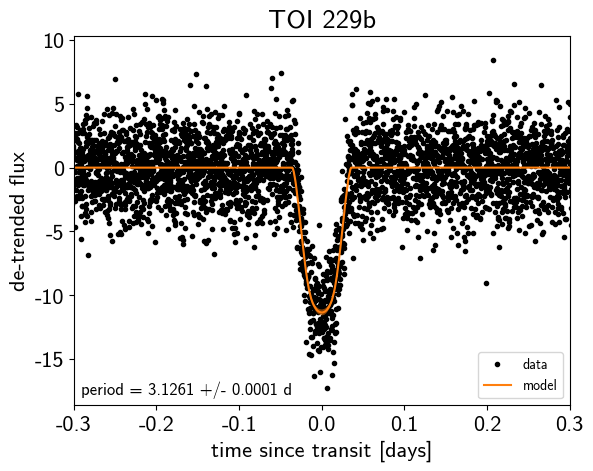

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

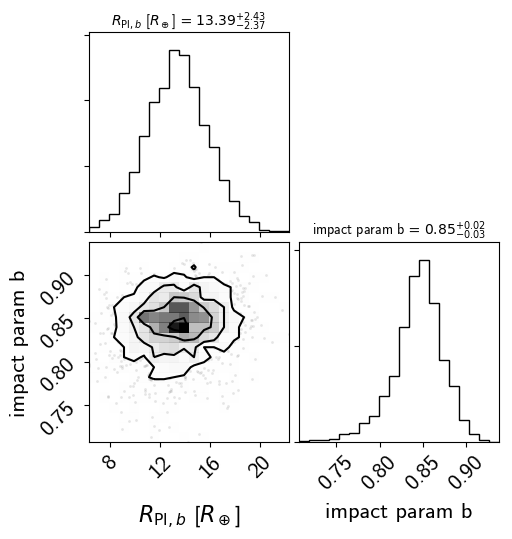

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

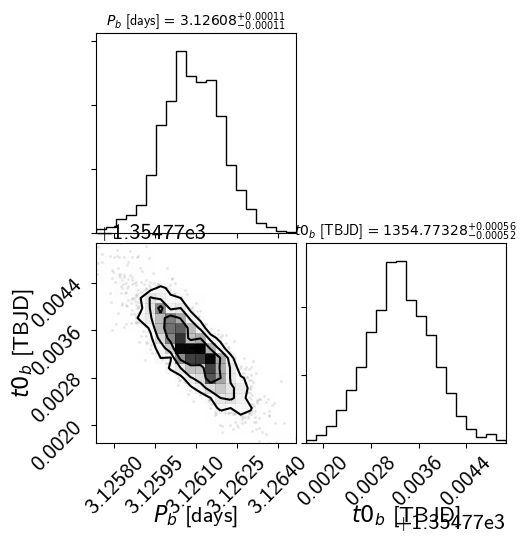

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

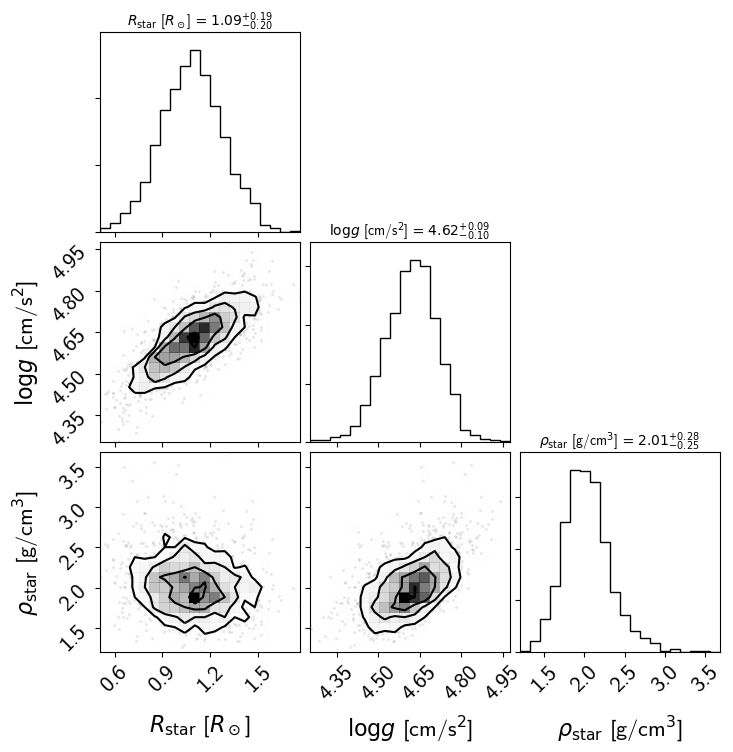

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3